**Table of contents**<a id='toc0_'></a>    
- [Résumé](#toc1_)    
  - [Problématique](#toc1_1_)    
  - [Tour d'horizon](#toc1_2_)    
  - [Tâches et cibles potentielles](#toc1_3_)    
  - [Feature engineering](#toc1_4_)    
  - [EDA et nettoyage](#toc1_5_)    
  - [Affinage de la cible pour la consommation énergétique totale](#toc1_6_)    
- [Introduction](#toc2_)    
  - [RGPD](#toc2_1_)    
  - [Imports et prérequis](#toc2_2_)    
  - [Fonctions spécifiques](#toc2_3_)    
  - [Chargement des données](#toc2_4_)    
- [Tour d'horizon](#toc3_)    
  - [Constat](#toc3_1_)    
- [Feature engineering](#toc4_)    
  - [Rappel des tâches et cibles potentielles](#toc4_1_)    
  - [Pré-traitement : doublons](#toc4_2_)    
  - [Données inutiles](#toc4_3_)    
  - [Données géographiques](#toc4_4_)    
  - [Outliers métier](#toc4_5_)    
  - [Proportion de parking](#toc4_6_)    
  - [Proportion de bâtiment](#toc4_7_)    
  - [Étages et surface](#toc4_8_)    
  - [Usages non résidentiels](#toc4_9_)    
  - [Données énergétiques](#toc4_10_)    
  - [Application du feature engineering](#toc4_11_)    
- [EDA](#toc5_)    
  - [Outliers statistiques](#toc5_1_)    
  - [Corrélations](#toc5_2_)    
  - [Variables cibles](#toc5_3_)    
- [Conclusion](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Résumé](#toc0_)

Liens utiles :
- [ce notebook avec les outputs](https://nbviewer.org/github/sycod/OC_projects/blob/main/P3/P3_EDA.ipynb)
- [projet OC](https://openclassrooms.com/fr/paths/794/projects/1509/assignment)

Sources métier :
- [données](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv)
- [source des données](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Energy Star Score](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results)
- [Glossaire Energy Star Score](https://portfoliomanager.energystar.gov/pm/glossary)

## <a id='toc1_1_'></a>[Problématique](#toc0_)

À partir des données provenant de la ville de Seattle, nous recherchons à prédire la consommation énergétique et l'émission de CO2 des bâtiments non destinés à l'habitation, tout en évaluant l'intérêt de l' "ENERGY STAR Score" dans les prédictions d'émissions.  
Tout nouveau bâtiment aura un premier relevé de référence la première année.  

👉 MISSION 1 → réaliser une **analyse exploratoire des données**  

**À partir des relevés existants et des données structurelles** des bâtiments (taille, usage, date de construction, situation géographique, ...) tenter de :  

MISSION 2 → **[prédire les émissions de CO2](./P3_ML_1_GHGE.ipynb)** pour les bâtiments non mesurés et **évaluer l'intérêt de l'ENERGY STAR Score** pour la prédiction d'émissions (fastidieux à calculer, à intégrer dans la modélisation)  
MISSION 3 → **[prédire la consommation totale d'énergie](./P3_ML_2_cons.ipynb)** pour les bâtiments non mesurés  

## <a id='toc1_2_'></a>[Tour d'horizon](#toc0_)

Les données sont **tout à fait exploitables** et nécessitent **peu de nettoyage** :
- très convenablement remplies : **aucun doublon ni index vide et peu de valeurs manquantes**
- les variables sont **majoritairement numériques** et quelques **variables catégorielles intéressantes vont devoir être traitées**
- certaines **variables inutiles ou faisant doublon vont également être supprimées**
- les **outliers qui n'apporteraient que du bruit** à nos données (peu nombreux) seront aussi supprimés

## <a id='toc1_3_'></a>[Tâches et cibles potentielles](#toc0_)

Pour les bâtiments **non destinés à l'habitation** :
1. Prédiction des **émissions de CO2** : variable cible = `GHGEmissionsIntensity` (normalisée par la surface)
2. Prédiction de la **consommation totale d'énergie** : variables potentielles = `SourceEUIWN(kBtu/sf)` et `SiteEUIWN(kBtu/sf)` (normalisation par surface + météorologique)
3. Évaluation de l'intérêt de l'`ENERGYSTARScore` pour la prédiction d'émissions : **imputation nécessaire**

## <a id='toc1_4_'></a>[Feature engineering](#toc0_)

<ins>DOUBLONS</ins>  
Pas de doublon actuellement mais choix de se prémunir d'un mauvais remplissage : supprression des doublons éventuels en amont des actions sur les variables.

<ins>DONNÉES INUTILES</ins>  
Suppression des variables qui desserviraient le modèle : Comments, DataYear, ListOfAllPropertyUseTypes, OSEBuildingID, PropertyName, TaxParcelIdentificationNumber, YearsENERGYSTARCertified

<ins>DONNÉES GÉOGRAPHIQUES</ins>  
Suppression de plusieurs variables : Adress, City, State, ZipCode, CouncilDistrictCode, Latitude, Longitude  
Variable conservée (catégorielle) : Neighborhood

<ins>OUTLIERS MÉTIER</ins>  
Outliers métier regroupés dans la variable ComplianceStatus, un booléen qui donne la conformité des données (représentent 165 individus, soit moins de 5% du jeu de données).  
👉 suppression des individus non conformes puis suppression des variables DefaultData, Outlier et ComplianceStatus

<ins>PROPORTION DE PARKING</ins>  
Utilisation des variables PropertyGFAParking, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType et ThirdLargestPropertyUseTypeGFA  
pour création d'un ratio de parking par rapport à la surface totale du bâtiment, appelé `ParkingRatio` (parfois > 1).

<ins>PROPORTION DE BÂTIMENT</ins>  
Création d'un ratio `BuildingRatio` : proportion de bâtiment sur la surface totale de l'immeuble, grâce à la variable PropertyGFABuilding(s).  
Le ratio, même cumulé au parking, n'est pas toujours de 1 (erreurs dans les données rentrées, sources multiples et point d'amélioration possible).  

<ins>SURFACE PAR BÂTIMENT</ins>  
`AreaPerBldg(sf)` créé à partir de la surface totale et du nombre déclaré de bâtiments sur une même propriété (NumberofBuildings).  
Application d'un minimum de 1 bâtiment aux individus dont NumberofBuildings est nul mais avec un BuildingRatio > 0.

<ins>NOMBRE D'ÉTAGES</ins>  
Nombre d'étages ambigu : correspond a priori au nombre d'étages cumulé des bâtiments d'une propriété et non à un maximum sur un seul bâtiment.  
Bâtiments déclarés à 0 étages et avec un BuildingRatio > 0 sont mis à un minimum de 1 étage ou sortis du jeu de données s'ils n'ont aucune surface de bâtiment (bruit statistique).  

<ins>SURFACE PAR ÉTAGE</ins>  
Création d'un ratio de surface par étage `AreaPerFloor(sf)` grâce au nombre d'étages.
Suppression des variables NumberofBuildings et NumberofFloors.

<ins>USAGES NON RÉSIDENTIELS</ins>  
Création d'un ratio d'usage non résidentiel `NonResidentialRatio` à partir des variables BuildingType, PrimaryPropertyType, LargestPropertyUseType, SecondLargestPropertyUseType et ThirdLargestPropertyUseType.  
Une restriction totale à un usage parfaitement non résidentiel enlève trop d'individus pour l'exploitation à venir. L'ajustement de ce ratio est nécessaire mais la position de ce curseur revient aux gens de métier.  
👉 Stratégie suivie :
- tous les usages avec moins de 0.01% de non résidentiel sont écartés
- une fonction d'aide à la décision permet de faire varier ce curseur d'usage non résidentiel au sein du modèle

<ins>DONNÉES ÉNERGÉTIQUES</ins>  
Choix de garder des unités énergétiques similaires et des données normalisées (par surface GFA ou par données météorologiques WN).
Suppression des variables Electricity(kWh), NaturalGas(therms), SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), TotalGHGEmissions.  
Variables conservées : SourceEUIWN(kBtu/sf), SiteEUIWN(kBtu/sf), GHGEmissionsIntensity.  
Variables SteamUse(kBtu), Electricity(kBtu) et NaturalGas(kBtu) remplacées par leur normalisation par la surface : `SteamUse_I(kBtu)`, `Electricity_I(kBtu)`, `NaturalGas_I(kBtu)`.  
Maintien des valeurs négatives ou nulles car possibilité d'un bilan énergétique nul ou positif.

## <a id='toc1_5_'></a>[EDA et nettoyage](#toc0_)

Un filtrage IQR est trop sélectif et ampute trop nos données, d'autant qu'il s'agit non pas d'outliers mais de valeurs atypiques.  
Une sélection manuelle, plus sélective et ciblée est choisie pour améliorer la qualité des données avec un impact très faible : 72 individus, soit 3% de la population.  
Un filtre plus sélectif devrait nécessairement être effectué par une personne de métier.

## <a id='toc1_6_'></a>[Affinage de la cible pour la consommation énergétique totale](#toc0_)

**Consommation totale d'énergie** la cible finalement définie est `SiteEUIWN(kBtu/sf)` (plus pertinente que `SourceEUIWN(kBtu/sf)` avec qui elle est très corrélée → suppression du jeu de données).

# <a id='toc2_'></a>[Introduction](#toc0_)

## <a id='toc2_1_'></a>[RGPD](#toc0_)

Les 5 grands principes des RGPD (Règlement Général sur la Protection des Données) **ne s'appliquent aucunement pour ces données, puisqu'il n'y a aucune information concernant les personnes** ou permettant d'identifier quelque personne.

Pour rappel, les principes sont les suivants :
- **finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **proportionnalité et pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **sécurité et confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **droits des personnes**

## <a id='toc2_2_'></a>[Imports et prérequis](#toc0_)

Pré-requis de fonctionnement :

Packages utilisés :

```
Python 3.9.18
-----
matplotlib          3.7.2
IPython             8.15.0
jupyter_client      7.4.9
jupyter_core        5.3.0
jupyterlab          3.6.3
notebook            6.5.4
numpy               1.21.0
pandas              2.0.3
plotly              5.9.0
scipy               1.10.0
seaborn             0.12.2
sklearn             1.2.1
```

In [36]:
import logging
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# render in GitHub & NBViewer
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# prevent warnings
pd.options.mode.chained_assignment = None

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc2_3_'></a>[Fonctions spécifiques](#toc0_)

### Tour d'horizon

In [37]:
def make_autopct(values):
    """
    ==> Obtained from StackOverflow <==
    Upgrades plt.pie(autopct=""), displaying percentages and values.
    
    Input: list of numeric values or Pandas.Series
    Output: string with percentage and value
    """

    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    
    return my_autopct

def plot_dtypes(df):
    """
    Quick data types pie view.

    Input: dataframe
    Output: pie plot

    Requirements: pandas, matplotplib
    """

    data_types = df.dtypes.value_counts()

    plt.pie(
        data_types,
        labels=data_types.index,
        autopct=make_autopct(data_types),
    )
    plt.show()

def nan_warn(df, nan_col="nan_pct", tags_col="tags", thresh=0.4):
    """
    Warns if NaNs outpass a defined threshold,
    warning showed as a tag in the dataframe on a defined column.

    Inputs:
    • df: dataframe
    • nan_col: dataframe column (string, default = "nan")
    • tags_col: dataframe column (string, default = "tags")
    • thresh: threshold for NaNs warning (float, default = 0.4)

    Output: modified dataframe

    Requirements: pandas
    """

    df_ = df.copy()
    mask = df_[nan_col] / 100 >= thresh
    df_.loc[mask, tags_col] = df_.loc[mask, tags_col] + "🚫"

    return df_

def type_tag(df,
             uni_col="unique",
             type_col="type",
             count_col="count",
             tags_col="tags"):
    """
    Defines a type tag of a dataframe feature,
    depending on unique values, count and dtype,
    and writes it in a tag column.

    Inputs:
    • df: dataframe
    • uni_col: dataframe column (string, default = "unique")
    • type_col: dataframe column (string, default = "type")
    • count_col: dataframe column (string, default = "type")
    • tags_col: dataframe column (string, default = "tags")

    Output: modified dataframe

    Requirements: pandas
    """

    df_ = df.copy()
    total_count = max(df_[count_col])

    # const warn
    const_mask = df_[uni_col] == 1
    df_.loc[const_mask, tags_col] = df_.loc[const_mask, tags_col] + "🔒"

    # unique warn
    uniq_mask = df_[uni_col] == total_count
    df_.loc[uniq_mask, tags_col] = df_.loc[uniq_mask, tags_col] + "💎"

    # bool = categorical feat
    is_bool_mask = df_[type_col] == "bool"
    df_.loc[is_bool_mask, tags_col] = df_.loc[is_bool_mask, tags_col] + "📦"
    
    # object categorical feat
    type_mask = df_[type_col] == "object"
    # define limit
    categ_limit = int(max(2, min(60, total_count / 1.2)))
    # filter
    categ_mask = df_[uni_col].between(2, categ_limit)
    df_.loc[(categ_mask & type_mask), tags_col] = df_.loc[
        (categ_mask & type_mask), tags_col] + "📦"

    return df_

def describe_df(df, nan_thresh=0.4):
    """
    Dataframe describer, include little more information than .describe()

    Inputs:
    • df: dataframe to be analysed
    • nan_thresh: threshold for NaNs warning (float, default = 0.4)

    Output: dataframe of data description

    Requirements: pandas, numpy
    """

    df_ = df.describe(include="all").T
    df_.sort_index(inplace=True)
    df_["unique"] = df.nunique()
    df_["type"] = df.dtypes
    df_["nan"] = df.isna().sum()
    df_["nan_pct"] = np.round(df.isna().mean()*100, 2)
    
    # tags column
    df_.insert(0, "tags", "")
    # nan warning tag
    df_ = nan_warn(df_, thresh=nan_thresh)
    # type check + const warn tag
    df_ = type_tag(df_,
        uni_col="unique",
        type_col="type",
        count_col="count",
        tags_col="tags",
    )
    
    df_ = df_.fillna("-")

    return df_

def percent_missing(df):
    """
    Returns a sorted dataframe of missing values percentage,
    by feature.

    Input: dataframe
    Output: dataframe of null values by feature

    Requirements: pandas
    """

    ds_isna_prct = np.round(df.isna().mean()*100)
    
    # set Series to DF for further display
    df_isna_prct = pd.DataFrame({
        "Feature Name": df.columns,
        "% missing": ds_isna_prct,
        }).sort_values(by=["% missing", "Feature Name"],
                       ascending=[False, True]
                       ).reset_index(drop=True)
    
    return df_isna_prct

def show_values_on_bars(axs, h_v="v", space=0.4):
    """
    ==> Obtained from StackOverflow <==
    Displays values at the end of an axis.

    Inputs
    • axs: graphic object axes
    • h_v: "v" or "h"
    • space: float between 0 and 1
    
    Output: none (acts on axis)

    Requirements: matplotlib
    """

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def heatmap_missing(df):
    """
    Heatmap of missing data.

    Input: dataframe
    Outputs:
    • Seaborn plot

    Requirements: pandas, numpy, matplotlib, seaborn
    """

    min_width = 8
    min_height = 6

    width = np.round(df.shape[0] / 200, 0)
    if width < min_width: width = min_width
    
    height = np.round(df.shape[1] / 4, 0)
    if height < min_height: height = min_height

    plt.figure(figsize=(width, height))
    sns.heatmap(df.isna().T)

    return plt

def plot_prct_missing(df, width=8):
    """
    Plot of NaN prct per column.

    Inputs:
    • dataframe
    • width and height for features missing plot
      (default = 8, 12)

    Outputs:
    • Seaborn plot

    Requirements: pandas, matplotlib, seaborn
    """

    data_nulls_by_value = percent_missing(df)

    min_height = 6
    height = np.round(data_nulls_by_value.shape[0] / 4, 0)
    if height < min_height: height = min_height

    plt.figure(figsize=(width, height))

    sns_t = sns.barplot(
        x="% missing", 
        y="Feature Name", 
        data=data_nulls_by_value, 
        color='#004767'
    )

    sns_t.xaxis.set_ticks_position("top")
    sns_t.xaxis.set_label_position('top')
    sns_t.axvline(x=20, ymin=0, linewidth=0.5, zorder=0)
    sns_t.axvline(x=40, ymin=0, linewidth=0.5, zorder=0)
    sns_t.axvline(x=60, ymin=0, linewidth=0.5, zorder=0)
    sns_t.axvline(x=80, ymin=0, linewidth=0.5, zorder=0)

    show_values_on_bars(sns_t, "h", 0.5)

    return plt

def show_duplicates(df):
    """
    Counts duplicates of a dataframe, plus eventually shows them.

    Input: dataframe
    Outputs:
    • duplicates count (int)
    • duplicates (dataframe)

    Requirements: pandas
    """
    
    duplicated_count = df.duplicated().sum()
    df_duplicated = df[df.duplicated()]

    if duplicated_count:
        print(f"{duplicated_count} duplicates:")
        display(df_duplicated)
    else:
        print("No duplicate.")
        
    return duplicated_count, df_duplicated

def show_no_index(df):
    """
    Counts empty indexes of a dataframe, plus eventually shows concerned rows.

    Input: dataframe
    Outputs:
    • empty indexes count (int)
    • empty indexed rows (dataframe)

    Requirements: pandas
    """
    
    no_index_count = df.index.isna().sum()
    df_no_index = df[df.index.isna()]

    if no_index_count:
        print(f"{no_index_count} empty indexes:")
        display(df_no_index)
    else:
        print("No empty index.")
        
    return no_index_count, df_no_index

def data_overview(df, width_miss_prct=8, nan_thresh=0.4):
    """
    Quick data overview with usual indicators.

    Inputs:
    • df: dataframe
    • show_boxplots: the name is quite clear (bool, default = False)
    • width_miss_prct: width for features missing plot (int, default = 8)
    • nan_thresh: threshold for NaNs warning (float, default = 0.4)

    Outputs:
    • transposed dataframe
    • duplicates (count and eventually show)
        -> output[0] = duplicated_count (int)
        -> output[1] = df_duplicated (dataframe)
    • empty indexes (count and eventually show)
        -> output[0] = no_index_count (int)
        -> output[1] = df_no_index (dataframe)
    • data types pie plot
    • dataframe complete description
    • NaNs heatmap
    • features missing percentage plot

    Requirements: numpy, pandas, matplotlib, seaborn
    """
    
    with pd.option_context('display.max_rows', 100):
        # display transposed data
        print("""
*******************************************************************************
                                TRANSPOSED DATA
*******************************************************************************
""")
        display(df.T)

        # show eventual duplicates
        print("""
*******************************************************************************
                                  DUPLICATES
*******************************************************************************
""")
        dup = show_duplicates(df)
        
        # show eventual empty indexes
        print("""
*******************************************************************************
                                EMPTY INDEXES
*******************************************************************************
""")
        no_index = show_no_index(df)

        # plot data types
        print("""
*******************************************************************************
                                  DATA TYPES
*******************************************************************************
""")
        plot_dtypes(df)
        
        # full dataframe description
        print("""
*******************************************************************************
                             DATA QUICK DESCRIPTION
*******************************************************************************
""")
        display(describe_df(df, nan_thresh=nan_thresh))
        
        # plot features missing percentage
        print("""
*******************************************************************************
                                 MISSING DATA
*******************************************************************************
""")
        heatmap_missing(df).show()
        plot_prct_missing(df, width_miss_prct).show()

    # outputs:
    # [0] = duplicated_count, df_duplicated
    # [1] = no_index_count, df_no_index
    return dup, no_index


### Nettoyage des données

In [38]:
def impact_classif(value, thresh=30):
    """
    Returns an impact classification depending on a value
    and a threshold.

    Positional arguments: 
    -------------------------------------
    value: float or int: between 0 and 100

    Optional arguments: 
    -------------------------------------
    thresh: float or int: threshold to adjust the function, default=30

    Output: string, warning intensity (int)
    """

    if value == 0:
        return "⌀", False
    elif 0 < value < (thresh / 6):
        return "--", False
    elif (thresh / 6) <= value < (thresh / 3):
        return "-", False
    elif (thresh / 3) <= value < (thresh * 2 / 3):
        return "+", False
    elif (thresh * 2 / 3) <= value < thresh:
        return "++", False
    elif thresh <= value < (thresh + (thresh / 3)):
        return "⚠️", 1
    elif (thresh + (thresh / 3)) <= value < (thresh + (2 * thresh / 3)):
        return "⚠️⚠️", 2
    elif (thresh + (2 * thresh / 3)) <= value < 75:
        return "⚠️⚠️⚠️", 3
    elif value >= 75:
        return "☠️", 4
    else:
        return "❓", False

def impact(df_before, df_after, monitored=None):
    """
    Returns an impact dataframe from an original and
    a second dataframe.
    Impact is calculated on the columns and population,
    plus on some optional arguments.

    Positional arguments: 
    -------------------------------------
    df_before: dataframe: original dataframe (starting point, before action)
    df_before: dataframe: original dataframe (starting point, after action)

    Optional arguments: 
    -------------------------------------
    monitored: list of strings: Columns to check.
               ⚠️ Columns must be present in both dataframes.
               Default = None

    Output: dataframe in logging.info()

    Required modules: pandas, numpy, logging
    """

    pop_bef = df_before.shape[0]
    cols_bef = df_before.shape[1]
    
    pop_aft = df_after.shape[0]
    cols_aft = df_after.shape[1]

    diff_pop = pop_bef - pop_aft
    diff_cols = cols_bef - cols_aft

    prct_pop_num = np.round(diff_pop / pop_bef * 100, 2)
    prct_cols_num = np.round(diff_cols / cols_bef * 100, 2)
    prct_pop = f"{prct_pop_num}%"
    prct_cols = f"{prct_cols_num}%"

    imp_cols = impact_classif(prct_cols_num)
    imp_pop = impact_classif(prct_pop_num)

    # list of potential warnings
    warn_logs = [imp_cols[1], imp_pop[1]]

    _df_ = pd.DataFrame([
        [cols_bef, pop_bef],
        [cols_aft, pop_aft],
        [diff_cols, diff_pop],
        [prct_cols, prct_pop],
        [imp_cols[0], imp_pop[0]]],
        columns=["Columns", "Population"],
        index=["Before", "After", "Difference", "Prct", "IMPACT"]
    )
    

    if monitored:
        for m in monitored:
            # get output from command
            before_ = df_before[m].count()
            after_ = df_after[m].count()
            prct_ = np.round((before_ - after_) / before_ * 100, 2)
            imp = impact_classif(prct_)
            # add in DF
            _df_[m] = [before_,
                    after_,
                    before_ - after_,
                    f"{prct_}%",
                    imp[0]
            ]
            # add potential warning
            warn_logs.append(imp[1])

    if (1 in warn_logs or 2 in warn_logs or 3 in warn_logs):
        return logging.warning(display(_df_))
    elif 4 in warn_logs:
        return logging.critical(display(_df_))
    else:
        return logging.info(display(_df_))

def feat_uniques(df, feature_name):
    """
    Returns how many unique values in a feature and a list of them.

    Inputs:
    • dataframe
    • feature name (string)

    Outputs:
    • count of unique values (int)
    • list of unique values (array)

    Requirements: pandas
    """

    u = df[feature_name].unique()
    u_count = pd.DataFrame(u).count()[0]

    print(f"{u_count} different {feature_name}")

    return u_count, u

def drop_dupl(df, verbose=True):
    """
    A verbose improvement of pd.DataFrame.drop_duplicates(),
    including impact on data.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: dataframe with no duplicate.

    Requirements: pandas, logging
    """

    nb_duplicates = df.duplicated().sum()
    df_ = df.drop_duplicates()

    # LOG
    if verbose:
        logging.info("\n👉👉 DUPLICATES DROP 👈👈")
        if nb_duplicates:
            logging.info(f"{nb_duplicates} duplicates dropped:")
            impact(df, df_)
        else:
            logging.info("No duplicate.")
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def clean_neighborhood(df, verbose=True):
    """
    Specified function for "Neighborhood" feature cleaning.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: dataframe with feature "Neighborhood" cleaned.

    Requirements: pandas, logging
    """

    df_ = df.copy()

    # LOG
    if verbose:
        logging.info("\n👉👉 NEIGHBORHOOD CLEANING 👈👈")
        logging.info("BEFORE: %s", df_["Neighborhood"].unique())

    # case harmonization
    df_["Neighborhood"] = df_["Neighborhood"].str.upper()
    # duplicate deletion
    df_.loc[df_["Neighborhood"] == "DELRIDGE NEIGHBORHOODS",
        "Neighborhood"] = "DELRIDGE"

    # LOG
    if verbose:
        logging.info("AFTER: %s", df_["Neighborhood"].unique())
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def keep_compliants(df, verbose=True):
    """
    Deletes non compliant data, as seen in "ComplianceStatus" feature.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: dataframe with only compliant data

    Requirements: pandas, logging
    """

    df_ = df.copy()

    df_ = df_.loc[df_["ComplianceStatus"] == "Compliant"]

    # LOG
    if verbose:
        logging.info("\n👉👉 DATA COMPLIANCE 👈👈")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def drop_empty_features(df, thresh=0.5, verbose=True):
    """
    Deletes features containing more than a specified NaN percentage.

    Inputs:
    • df: dataframe
    • thresh: minimum part of NaNs to drop a column (float, default = 0.5)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: dataframe with filtered columns

    Requirements: pandas, logging
    """

    df_ = df.loc[:, df.isna().mean() < thresh]
    dropped_list = [f for f in df.columns if f not in df_.columns]

    # LOG
    if verbose:
        logging.info("\n👉👉 EMPTY FEATURES DROP 👈👈")
        if len(dropped_list) > 0:
            logging.info(f"Features dropped: {dropped_list}")
            impact(df, df_)
        else:
            logging.info("No empty feature.")
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def delete_useless_feats(df, features_list, verbose=True):
    """
    Useless features deletion.

    Inputs:
    • df: dataframe
    • features_list: features list to delete (strings list)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: dataframe with no useless feature

    Requirements: pandas, logging
    """

    df_ = df.copy()
    df_.drop(features_list, axis=1, inplace=True)

    # LOG
    if verbose:
        logging.info("\n👉👉 USELESS FEATURES DELETION 👈👈")
        logging.info("Features deleted: {}".format(*features_list))
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def drop_na(df, thresh, verbose=True):
    """
    A verbose improvement of pd.DataFrame.dropna(),
    including impact on data.

    Inputs:
    • df: dataframe
    • thresh: threshold of at least N non-NaNs to be kept (int)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: cleansed dataframe

    Requirements: pandas, logging
    """

    df_ = df.copy()
    df_.dropna(thresh=thresh, inplace=True)

    # LOG
    if verbose:
        logging.info(f"\n👉👉 NANs DROP (< {thresh} non-NAN) 👈👈")
        if (df.shape[0] - df_.shape[0]) > 0:
            impact(df, df_)
        else:
            logging.info("No NaN.")
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def dropna_but_feats(df, features, verbose=True):
    """
    A second verbose improvement of pd.DataFrame.dropna(),
    including impact on data, dropping all NaNs.

    Inputs:
    • df: dataframe
    • features: list of features (strings)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: cleansed dataframe

    Requirements: pandas, logging
    """

    df_ = df.copy()

    df_.dropna(subset=df_.columns.difference(features), inplace=True)

    # LOG
    if verbose:
        logging.info(f"\n👉👉 NANs second DROP 👈👈")
        logging.info(f"Features excluded: {features}")
        if (df.shape[0] - df_.shape[0]) > 0:
            impact(df, df_)
        else:
            logging.info("No NaN.")
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def list_building_types(df, verbose=True):
    """
    Specific function:
    - creates a dataframe of all usage types
    - added with bool values (residential / non residential)

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: building types dataframe

    Requirements: pandas, logging
    """

    # get each unique value
    use_types_bt = pd.DataFrame(df["BuildingType"].unique(),
        columns=["use_type"]).dropna()

    use_types_ppt = pd.DataFrame(df["PrimaryPropertyType"].unique(),
        columns=["use_type"]).dropna()

    use_types_lut = pd.DataFrame(df["LargestPropertyUseType"].unique(),
        columns=["use_type"]).dropna()

    use_types_sut = pd.DataFrame(df["SecondLargestPropertyUseType"].unique(),
        columns=["use_type"]).dropna()

    use_types_tut = pd.DataFrame(df["ThirdLargestPropertyUseType"].unique(),
        columns=["use_type"]).dropna()

    # all together
    use_types = pd.concat([use_types_bt,
        use_types_ppt,
        use_types_lut,
        use_types_sut,
        use_types_tut],
        ignore_index=True
    )

    # clean, lower, sort
    use_types.drop_duplicates(inplace=True, ignore_index=True)
    use_types.sort_values(by=["use_type"], inplace=True, ignore_index=True)

    # add residential bool
    use_types["residential"] = use_types['use_type']\
        .str.lower()\
        .str.contains(r'(?<!(non))(residential|multifamily|residence)')

    # LOG
    if verbose:
        logging.info(display(use_types.loc[use_types["residential"] == True]))

    return use_types

def non_res_pct(df, verbose=True):
    """
    Specific function which compiles all usage feats in one non-residential
    ratio.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()
    df_["non_res_gfa"] = 0

    lput_notna = df_["LargestPropertyUseType"] != np.NaN
    cols = ["ThirdLargestPropertyUseType", "SecondLargestPropertyUseType",
        "LargestPropertyUseType"
    ]

    # LargestPropertyUseType != NaN
    for c in cols:
        gfa = c + "GFA"
        is_res = df_[c].str.lower().str.contains(
            r'(?<!(non))(residential|multifamily|residence)', na=True)
        df_[gfa].mask(lput_notna & is_res, 0, inplace=True)
        # add GFA to total
        df_["non_res_gfa"] += df_[gfa]

    # LargestPropertyUseType == NaN
    zero_non_res_gfa = df_["non_res_gfa"] != 0
    is_res = df_["PrimaryPropertyType"].str.lower().str.contains(
        r'(?<!(non))(residential|multifamily|residence)', na=True)
    df_["non_res_gfa"].where(lput_notna & is_res | zero_non_res_gfa,
        df_["PropertyGFATotal"], inplace=True)

    # LOG
    if verbose:
        # for DEBUG only
        # columns_to_check = ["PrimaryPropertyType",
        #     "PropertyGFATotal",
        #     "LargestPropertyUseType",
        #     "LargestPropertyUseTypeGFA",
        #     "SecondLargestPropertyUseType",
        #     "SecondLargestPropertyUseTypeGFA",
        #     "ThirdLargestPropertyUseType",
        #     "ThirdLargestPropertyUseTypeGFA",
        #     "non_res_gfa"
        # ]
        # logging.info("NON RESIDENTIAL GFA CHECK")
        # logging.info(display(df_.iloc[:60][columns_to_check]))
        logging.info("\n👉👉 NON-RESIDENTIAL PERCENTAGE 👈👈")
        logging.info("✅ Non residential GFA created")


    # apply % on total GFA
    df_["NonResidentialRatio"] = df_["non_res_gfa"] / df_["PropertyGFATotal"]
    df_.loc[df_["NonResidentialRatio"] > 1, "NonResidentialRatio"] = 1

    # LOG
    if verbose:
        # for DEBUG only
        # logging.info("NON RESIDENTIAL PERCENTAGE CHECK")
        # columns_to_check = ["PrimaryPropertyType", "PropertyGFATotal",
        #     "non_res_gfa", "NonResidentialRatio"]
        # logging.info(display(df_.iloc[:60][columns_to_check]))
        logging.info("✅ Non residential percentage created")

    # delete useless columns
    df_ = df_.drop(columns=[
        "BuildingType",
        "PrimaryPropertyType",
        "LargestPropertyUseType",
        "LargestPropertyUseTypeGFA",
        "SecondLargestPropertyUseType",
        "SecondLargestPropertyUseTypeGFA",
        "ThirdLargestPropertyUseType",
        "ThirdLargestPropertyUseTypeGFA",
        "non_res_gfa",
    ])

    # LOG
    if verbose:
        logging.info("✅ Useless features dropped")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def cut_under_non_res_pct(df, min_nr_pct=1, verbose=True):
    """
    Specific function which selects only individuals over a certain
    non-residential usage percentage.

    Inputs:
    • df: dataframe
    • min_nr_pct: percentage under which population is dropped
        (float, default = 1)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()

    df_ = df_.loc[(df_["NonResidentialRatio"] >= min_nr_pct)]
    # df_.drop(columns=["NonResidentialRatio"], inplace=True)

    # LOG
    if verbose:
        logging.info("\n👉👉 NON-RESIDENTIAL PERCENTAGE SELECTION 👈👈")
        logging.info(f"Percentage selected = {min_nr_pct:.2%}")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def pkg_pct(df, verbose=True):
    """
    Specific function which searches parking usage in all usage feats
    to create a parking usage percentage.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()
    df_["pkg_gfa"] = 0

    # seek parking GFA and add up
    cols = ["ThirdLargestPropertyUseType", "SecondLargestPropertyUseType",
        "LargestPropertyUseType"
    ]
    for c in cols:
        gfa = c + "GFA"
        is_pkg = df_[c].str.lower().str.contains(r'parking', na=False)
        df_[gfa].where(is_pkg, 0, inplace=True)
        # add GFA to total
        df_["pkg_gfa"] += df_[gfa]

    # keep highest GFA
    df_.loc[df_["pkg_gfa"] > df_["PropertyGFAParking"],
        "PropertyGFAParking"] = df_["pkg_gfa"]

    # LOG
    if verbose:
        # for DEBUG only
        # columns_to_check = ["PropertyGFATotal",
        #     "PropertyGFAParking",
        #     "LargestPropertyUseType",
        #     "LargestPropertyUseTypeGFA",
        #     "SecondLargestPropertyUseType",
        #     "SecondLargestPropertyUseTypeGFA",
        #     "ThirdLargestPropertyUseType",
        #     "ThirdLargestPropertyUseTypeGFA",
        #     "pkg_gfa"
        # ]
        # logging.info("PARKING GFA CHECK")
        # logging.info(display(df_.iloc[:60][columns_to_check]))
        logging.info("\n👉👉 PARKING PERCENTAGE 👈👈")
        logging.info("✅ Parking GFA created")

    # apply % on total GFA
    df_["ParkingRatio"] = df_["PropertyGFAParking"] / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        # for DEBUG only
        # logging.info("NON RESIDENTIAL PERCENTAGE CHECK")
        # columns_to_check = ["PropertyGFAParking", "PropertyGFATotal",
        #     "pkg_gfa", "ParkingRatio"]
        # logging.info(display(df_.iloc[:60][columns_to_check]))
        logging.info("✅ Parking percentage created")

    # delete useless columns
    df_ = df_.drop(columns=[
        "PropertyGFAParking",
        "pkg_gfa",
    ])

    # LOG
    if verbose:
        logging.info("✅ Useless features dropped")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def bldg_pct(df, verbose=True):
    """
    Specific function which converts building GFA in building ratio.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()
    df_["BuildingRatio"] = df_["PropertyGFABuilding(s)"] / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        # for DEBUG only
        # columns_to_check = ["PropertyGFATotal",
        #     "PropertyGFAParking",
        #     "PropertyGFABuilding(s)",
        #     "BuildingRatio",
        # ]
        # logging.info(display(df_.iloc[:60][columns_to_check]))
        logging.info("\n👉👉 BUILDING RATIO 👈👈")
        logging.info("✅ Building ratio created")

    # delete useless columns
    df_ = df_.drop(columns=["PropertyGFABuilding(s)"])

    # LOG
    if verbose:
        logging.info("✅ Useless features dropped")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def energy_per_sf(df, verbose=True):
    """
    Converts energy value into intensity (value per square feet).

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()
    df_["SteamUse_I(kBtu/sf)"] = df_["SteamUse(kBtu)"]\
        / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        logging.info("\n👉👉 ENERGY INTENSITY CONVERSION 👈👈")
        logging.info("✅ SteamUse(kBtu) -> SteamUse_I(kBtu/sf)")
        
    df_["Electricity_I(kBtu/sf)"] = df_["Electricity(kBtu)"]\
        / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        logging.info("✅ Electricity(kBtu) -> Electricity_I(kBtu/sf)")

    df_["NaturalGas_I(kBtu/sf)"] = df_["NaturalGas(kBtu)"]\
        / df_["PropertyGFATotal"]
    
    # LOG
    if verbose:
        logging.info("✅ NaturalGas(kBtu) -> NaturalGas_I(kBtu/sf)")

    # delete useless columns
    df_ = df_.drop(columns=[
        "SteamUse(kBtu)",
        "Electricity(kBtu)",
        "NaturalGas(kBtu)",
    ])

    # LOG
    if verbose:
        logging.info("✅ Useless features dropped")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def sf_per_floor(df, verbose=True):
    """
    Creates an average square foot area per floor feature.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()

    # 1 floor minimum
    df_.loc[(df_["NumberofFloors"] == 0) & (df_["BuildingRatio"] > 0),
        "NumberofFloors"] = 1

    # LOG
    if verbose:
        logging.info("\n👉👉 AREA PER FLOOR CREATION 👈👈")
        logging.info("✅ Minimum number of floors set to 1")

    df_["AreaPerFloor(sf)"] = df_["NumberofFloors"]\
        / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        logging.info("✅ New columns created: 'AreaPerFloor(sf)'")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def sf_per_building(df, verbose=True):
    """
    Creates an average square foot area per floor feature.

    Inputs:
    • df: dataframe
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()

    # 1 building minimum
    df_.loc[(df_["NumberofBuildings"] == 0) & (df_["BuildingRatio"] > 0),
        "NumberofBuildings"] = 1

    # LOG
    if verbose:
        logging.info("\n👉👉 AREA PER BUILDING CREATION 👈👈")
        logging.info("✅ Minimum number of buildings set to 1")

    df_["AreaPerBldg(sf)"] = df_["NumberofBuildings"]\
        / df_["PropertyGFATotal"]

    # LOG
    if verbose:
        logging.info("✅ New columns created: 'AreaPerBldg(sf)'")
        impact(df, df_)
        logging.info("\n🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹\n")

    return df_

def d_cleaner(df, min_nr_pct=1, verbose=True):
    """
    Data cleaner, with data impact monitored.

    Inputs:
    • df: dataframe
    • min_nr_pct: percentage under which population is dropped
        (float, default = 1)
    • verbose: determines whether logs are shown or not (bool, default = True)

    Output: clean dataframe

    Requirements: pandas, logging
    """

    # drop duplicates
    df_ = drop_dupl(df, verbose)

    # delete non compliants
    df_ = keep_compliants(df_, verbose)

    # clean neighborhood feature
    df_ = clean_neighborhood(df_, verbose)

    # delete useless features
    df_ = delete_useless_feats(df_, [
        "Address",
        "City",
        "Comments",
        "ComplianceStatus",
        "CouncilDistrictCode",
        "DataYear",
        "DefaultData",
        "Electricity(kWh)",
        "Latitude",
        "Longitude",
        "ListOfAllPropertyUseTypes",
        "NaturalGas(therms)",
        "OSEBuildingID",
        "Outlier",
        "PropertyName",
        "SiteEnergyUse(kBtu)",
        "SiteEnergyUseWN(kBtu)",
        "SiteEUI(kBtu/sf)",
        "SourceEUI(kBtu/sf)",
        "State",
        "TaxParcelIdentificationNumber",
        "TotalGHGEmissions",
        "YearsENERGYSTARCertified",
        "ZipCode",
        ], verbose)
    
    # delete empty rows
    df_ = drop_na(df_, 12, verbose)

    # parking percentage
    df_ = pkg_pct(df_, verbose)

    # building percentage
    df_ = bldg_pct(df_, verbose)

    # compile all usage feats in one non-residential percentage
    df_ = non_res_pct(df_, verbose)

    # drops population under a non-residential percentage
    df_ = cut_under_non_res_pct(df_, min_nr_pct, verbose)

    # changes raw energy values to energy intensity
    df_ = energy_per_sf(df_, verbose)

    # sets minimum number of floors to 1
    # and adds an area per floor feature
    df_ = sf_per_floor(df_, verbose)

    # sets minimum number of buildings to 1
    # and adds an area per building feature
    df_ = sf_per_building(df_, verbose)

    # drop remaining nans but Energy Star Score
    feats = ["ENERGYSTARScore"]
    df_ = dropna_but_feats(df_, feats, verbose)

    # sort DF columns
    df_.sort_index(axis=1, inplace=True)

    # show global impact
    if verbose:
        logging.info("""\n***************************************************
    👇👇   GLOBAL IMPACT  👇👇""")
        impact(df, df_)

    return df_


### EDA

In [39]:
def distri_cor(df, features, target=None, boxplot=True, pairplot=False,
    corr=False):
    """
    Quick graphic tour of the distribution with boxplots and pairplot.

    Inputs:
    • df: dataframe
    • features: features to plot (list of strings, don't forget target)
    • target: target feature for pairplot hue (string, default = None)
    • boxplot: shows boxplots if True (bool, default = True)
    • pairplot: shows pairplot if True (bool, default = False)
    • corr: shows correlation matrix if True (bool, default = False)

    Outputs:
    • selected plots

    Requirements: pandas, numpy, seaborn, plotly
    """

    df_ = df[features]

    if boxplot:

        # setup display
        cols = 6
        rows = int(np.ceil(len(features) / cols))
        fig = make_subplots(rows=rows, cols=cols)

        # plot each boxplot within display
        r = 0
        for i,f in enumerate(df_.columns):
            c = (i % cols) + 1
            # next row
            if c == 1: r += 1
            # plot it
            fig.add_trace(
                go.Box(
                    y=df[f],
                    name=f,
                    showlegend=False,
                    boxmean='sd'
                    ),
                row=r, col=c,
            )

        fig.update_xaxes(tickangle=45)
        fig.update_layout(height=600 * r)
        fig.show()
        
    if pairplot:
        sns.pairplot(
            df_,
            corner=True,
            hue=target,
            plot_kws={"s": 2}, # reduced dots size to avoid overplotting
        )
        
        plt.show()

    if corr:
        # matrix correlation
        corr_mtx = df.corr(numeric_only=True).round(3)

        # mask for the upper half
        mask = np.triu(np.ones_like(corr_mtx, dtype=bool))

        f, ax = plt.subplots(figsize=(11, 7))
        sns.heatmap(corr_mtx,
            annot = True,
            mask=mask,
            linewidths=.5,
        )

        plt.show()

    return

def bin_prct(prct):
    """
    Changes a percentage float in a class range string.
    Ugly but strong.

    Input: float
    Output: string
    """

    if (prct >= 10 and prct < 20):
        return "10-20%"
    elif (prct >= 20 and prct < 30):
        return "20-30%"
    elif (prct >= 30 and prct < 40):
        return "30-40%"
    elif (prct >= 40 and prct < 50):
        return "40-50%"
    elif (prct >= 50 and prct < 60):
        return "50-60%"
    elif (prct >= 60 and prct < 70):
        return "60-70%"
    elif (prct >= 70 and prct < 80):
        return "70-80%"
    elif (prct >= 80 and prct < 90):
        return "80-90%"
    elif (prct >= 90 and prct <= 100):
        return "90-100%"
    else:
        return "0-10%"

def iqr_filter(df, feature, floor=True, ceil=True, verbose=False):
    """
    IQR filter.
    Returns a filtered dataframe
    and displays impact on feature if verbose is on.

    Inputs
    • df: dataframe
    • feature: feature name (string)
    • floor: whether IQR filters low outliers or not (bool, default = True)
    • ceil: whether IQR filters high outliers or not (bool, default = True)
    • verbose: determines whether logs are shown or not (bool, default = False)
    
    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()

    q1 = df_[feature].quantile(0.25)
    q3 = df_[feature].quantile(0.75)
    iqr = q3-q1

    floor_mask = df_[feature] < (q1-(1.5*iqr))
    ceil_mask = df_[feature] > (q3+(1.5*iqr))

    if (floor == False) and (ceil == False):
        return logging.warning("""
        ⚠️ No filter because neither floor nor ceil defined ⚠️""")
    elif floor == False:
        df_[feature] = df_[feature]\
            .mask(ceil_mask)
    elif ceil == False:
        df_[feature] = df_[feature]\
            .mask(floor_mask)
    else:
        df_[feature] = df_[feature]\
            .mask(floor_mask)\
            .mask(ceil_mask)

    # LOG
    if verbose:
        logging.info("👉👉 IQR FILTER 👈👈")
        impact(df, df_)
    
    return df_

def chase_outliers(df, features, verbose=True):
    """
    Uses the IQR filter in a specific way.

    Inputs
    • df: dataframe
    • features: list of features names (strings)
    • verbose: determines whether logs are shown or not (bool, default = False)
    
    Output: modified dataframe

    Requirements: pandas, numpy, logging
    """

    df_ = df.copy()

    # same IQR filter for all features, modify if needed
    for f in features:
        df_ = iqr_filter(df_, f)

    # LOG
    if verbose:
        logging.info("👉👉 NO MORE OUTLIERS (IQR filter) 👈👈")
        impact(df, df_, features)

    return df_

def match_cond(df, cols, cond1, *conds, display_df=True):
    """
    Returns an impact dataframe from an original and a second dataframe.
    Impact is calculated on columns and population, plus some optional args.

    Inputs:
    • df: dataframe: original dataframe (starting point, before action)
    • cols: dataframe: original dataframe (starting point, after action)
            ⚠️ Columns order: 1st column must be the same as 1st cond1
    • cond1: dataframe: original dataframe (starting point, after action)
    • display_df: bool: choose to either display DF or not

    Optional arguments:
    • conds: strings: Columns and methods or conditions applied to dataframes,
             default=None
             example: "BuildingType.unique()"

    Output: information and dataframe

    Requirements: pandas, numpy
    """

    df_cond1 = eval("df.loc[df"
        + cond1
        + ", cols]"
    )
    nb_cond1 = df_cond1.shape[0]
    prct_pres = np.round(nb_cond1 / df.shape[0] * 100, 2)

    print(f"Condition {cond1}: {nb_cond1} individuals "
        + f"on {df.shape[0]} = "
        + f"{prct_pres}%")
    
    # if declared, filters with all conditions
    # and gives the presence of 1st condition inside
    if conds:
        cond1_ = "(df" + cond1 + ")"
        conds_ = []
        
        for cond in conds:
            conds_.append(" & (df" + cond + ")")
        
        df_conds = eval("df.loc["
            + cond1_
            + "".join(conds_)
            + ", cols]"
        )
        
        matches = df_cond1.isin(df_conds)
        nb_matches = matches[matches[cols[0]] == True].shape[0]
        prct_matches = np.round(nb_matches / nb_cond1 * 100, 2)

        print("Presence in global filter: "
        + f"{nb_matches} individuals on {nb_cond1} = {prct_matches}% match")
        if display_df: display(df_cond1)
        return prct_matches

    else:
        if display_df: display(df_cond1)
        return prct_pres


## <a id='toc2_4_'></a>[Chargement des données](#toc0_)

In [40]:
DATASETS_PATH = "./"
dataset_name = "oc_p3_2016_Building_Energy_Benchmarking.csv"

data_raw = pd.read_csv(DATASETS_PATH+dataset_name)

# <a id='toc3_'></a>[Tour d'horizon](#toc0_)


*******************************************************************************
                                TRANSPOSED DATA
*******************************************************************************



,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375
OSEBuildingID,1,2,3,5,8,9,10,11,12,13,...,50210,50212,50219,50220,50221,50222,50223,50224,50225,50226
DataYear,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
BuildingType,NonResidential,NonResidential,NonResidential,NonResidential,NonResidential,Nonresidential COS,NonResidential,NonResidential,NonResidential,Multifamily MR (5-9),...,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS
PrimaryPropertyType,Hotel,Hotel,Hotel,Hotel,Hotel,Other,Hotel,Other,Hotel,Mid-Rise Multifamily,...,Office,Other,Mixed Use Property,Office,Other,Office,Other,Other,Mixed Use Property,Mixed Use Property
PropertyName,Mayflower park hotel,Paramount Hotel,5673-The Westin Seattle,HOTEL MAX,WARWICK SEATTLE HOTEL (ID8),West Precinct,Camlin,Paramount Theatre,311wh-Pioneer Square,Lyon Building,...,Central West HQ / Brown Bear,Conservatory Campus,Garfield Community Center,Genesee/SC SE HQ,High Point Community Center,Horticulture building,International district/Chinatown CC,Queen Anne Pool,South Park Community Center,Van Asselt Community Center
Address,405 Olive way,724 Pine street,1900 5th Avenue,620 STEWART ST,401 LENORA ST,810 Virginia St,1619 9th Avenue,911 Pine St,612 2nd Ave,607 - 3rd Ave.,...,1403 w howe,1400 E Galer St,2323 East Cherry St,4420 S Genesee,6920 34th Ave SW,1600 S Dakota St,719 8th Ave S,1920 1st Ave W,8319 8th Ave S,2820 S Myrtle St
City,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,...,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle
State,WA,WA,WA,WA,WA,WA,WA,WA,WA,WA,...,WA,WA,WA,WA,WA,WA,WA,WA,WA,WA
ZipCode,98101.0,98101.0,98101.0,98101.0,98121.0,98101.0,98101.0,98101.0,98104.0,98104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TaxParcelIdentificationNumber,0659000030,0659000220,0659000475,0659000640,0659000970,0660000560,0660000825,0660000955,0939000080,0939000105,...,2425039137,2925049087,7544800245,4154300585,2524039059,1624049080,3558300000,1794501150,7883603155,7857002030



*******************************************************************************
                                  DUPLICATES
*******************************************************************************

No duplicate.

*******************************************************************************
                                EMPTY INDEXES
*******************************************************************************

No empty index.

*******************************************************************************
                                  DATA TYPES
*******************************************************************************



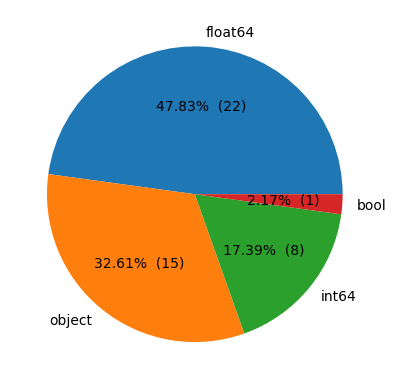


*******************************************************************************
                             DATA QUICK DESCRIPTION
*******************************************************************************



,tags,count,unique,top,freq,mean,std,min,25%,50%,75%,max,type,nan,nan_pct
Address,,3376.0,3354,2600 SW Barton St,4,-,-,-,-,-,-,-,object,0,0.00
BuildingType,📦,3376.0,8,NonResidential,1460,-,-,-,-,-,-,-,object,0,0.00
City,🔒,3376.0,1,Seattle,3376,-,-,-,-,-,-,-,object,0,0.00
Comments,🚫,0.0,0,-,-,-,-,-,-,-,-,-,float64,3376,100.00
ComplianceStatus,📦,3376.0,4,Compliant,3211,-,-,-,-,-,-,-,object,0,0.00
CouncilDistrictCode,,3376.0,7,-,-,4.439277,2.120625,1.0,3.0,4.0,7.0,7.0,int64,0,0.00
DataYear,🔒,3376.0,1,-,-,2016.0,0.0,2016.0,2016.0,2016.0,2016.0,2016.0,int64,0,0.00
DefaultData,📦,3376.0,2,False,3263,-,-,-,-,-,-,-,bool,0,0.00
ENERGYSTARScore,,2533.0,100,-,-,67.918674,26.873271,1.0,53.0,75.0,90.0,100.0,float64,843,24.97
Electricity(kBtu),,3367.0,3351,-,-,3707612.161594,14850656.138963,-115417.0,639487.0,1177583.0,2829632.5,657074389.0,float64,9,0.27



*******************************************************************************
                                 MISSING DATA
*******************************************************************************



DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024EAB4C1F70>


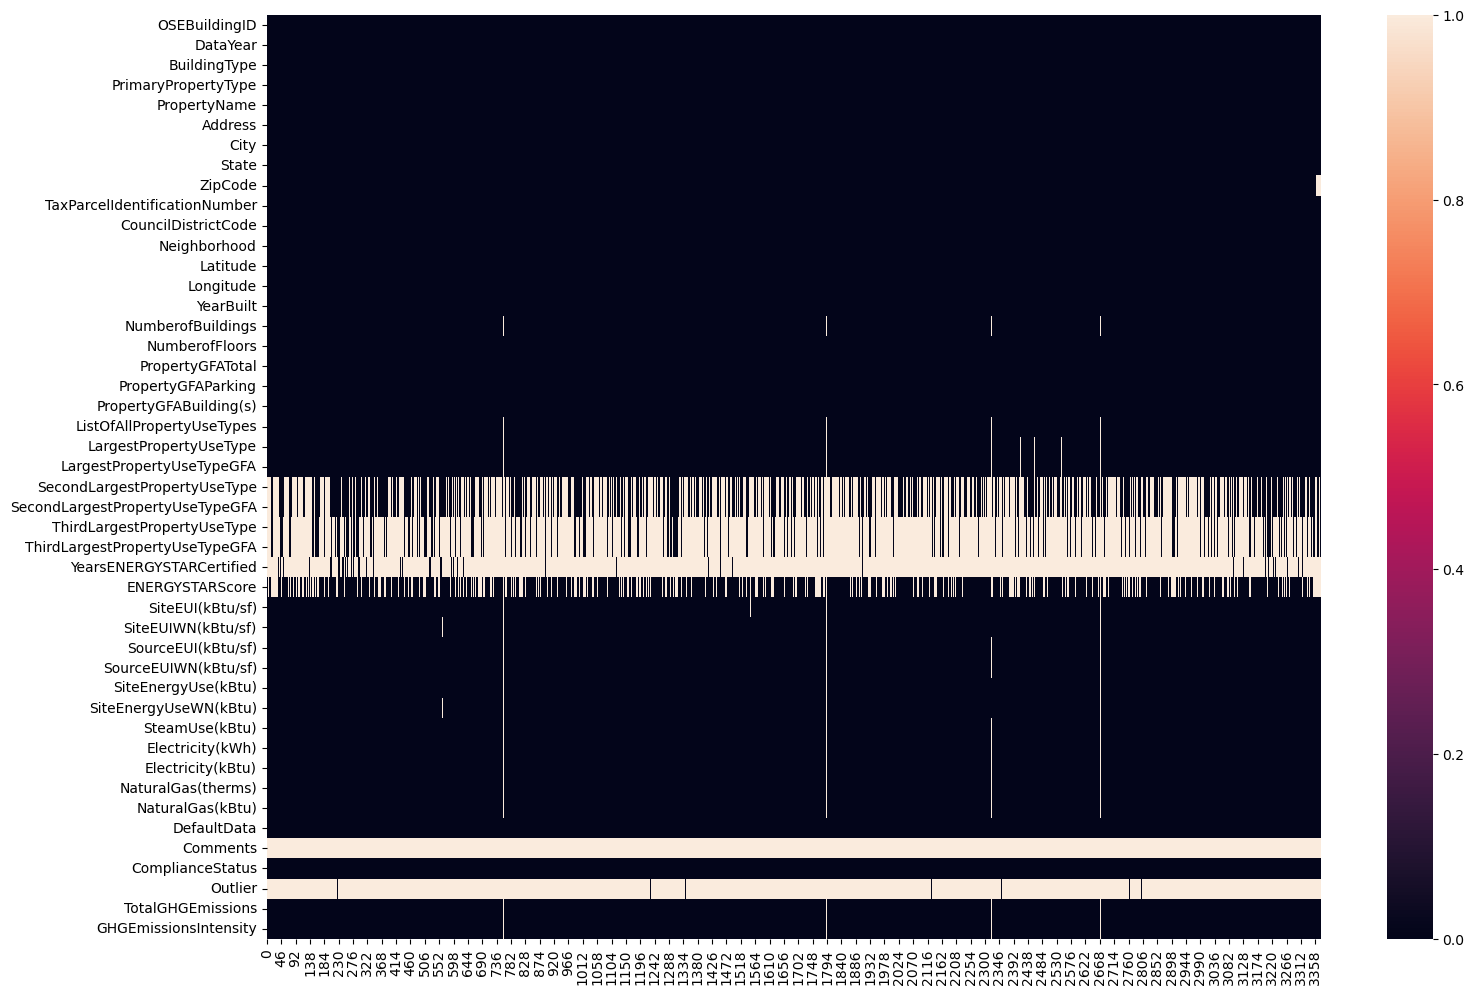

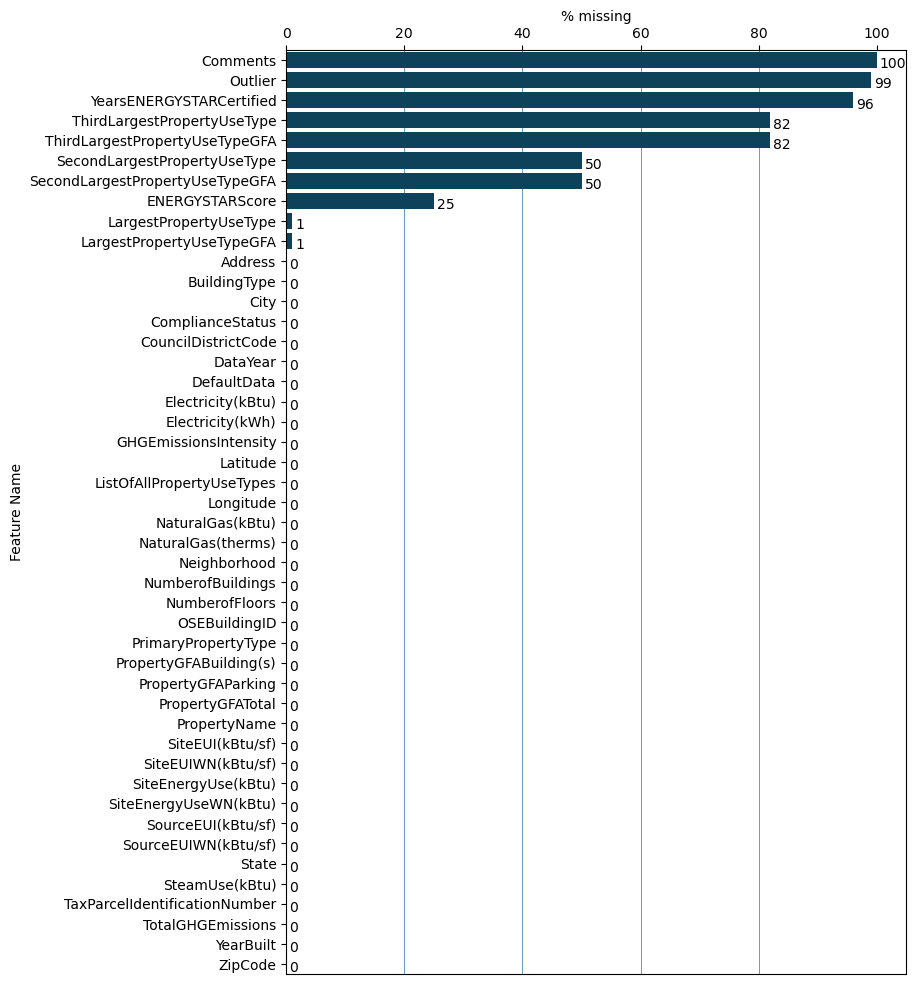

In [41]:
z = data_overview(data_raw)

## <a id='toc3_1_'></a>[Constat](#toc0_)

À ce jour, les données sont **tout à fait exploitables** et nécessitent **peu de nettoyage** :
- très convenablement remplies : **aucun doublon ni index vide et peu de valeurs manquantes** (un traitement automatique des doublons sera tout de même proposé car le jeu de données est susceptible d'évoluer)
- les variables sont majoritairement numériques et quelques **variables catégorielles intéressantes vont devoir être traitées**
- certaines **variables inutiles ou faisant doublon vont également être supprimées**
- les **outliers qui n'apporteraient que du bruit** à nos données (peu nombreux) seront aussi supprimés

# <a id='toc4_'></a>[Feature engineering](#toc0_)

## <a id='toc4_1_'></a>[Rappel des tâches et cibles potentielles](#toc0_)

Individus concernés : bâtiments **non destinés à l'habitation**

1. Prédiction des **émissions de CO2** : variable principale = `GHGEmissionsIntensity` puisqu'elle est normalisée sur la surface du bâtiment
2. Prédiction de la **consommation totale d'énergie** : variables possibles = `SourceEUIWN(kBtu/sf)` et `SiteEUIWN(kBtu/sf)` pour leur normalisation par surface et météorologique (explications ci-après)
3. Évaluation de l'intérêt de l'`ENERGYSTARScore` pour la prédiction d'émissions : nécessité d'**imputer cette variable pour l'analyse**²

## <a id='toc4_2_'></a>[Pré-traitement : doublons](#toc0_)

Bien qu'il n'y ait actuellement pas de doublon dans le jeu de données et un ID propre à chaque bâtiment, on peut se prémunir d'un mauvais remplissage en **supprimant les doublons éventuels en amont des actions sur les variables**, sans quoi il y a un **risque de détecter les doublons créés par ces mêmes actions**.

## <a id='toc4_3_'></a>[Données inutiles](#toc0_)

Afin de ne pas ajouter de **données non nécessaires qui desserviraient les modèles** à venir, plusieurs variables peuvent d'ores-et-déjà être supprimées :
- Comments
- DataYear
- ListOfAllPropertyUseTypes
- OSEBuildingID
- PropertyName
- TaxParcelIdentificationNumber
- YearsENERGYSTARCertified

## <a id='toc4_4_'></a>[Données géographiques](#toc0_)

Analyses de quelques variables géographiques :

In [42]:
neigh = feat_uniques(data_raw, "Address")
neigh = feat_uniques(data_raw, "City")
neigh = feat_uniques(data_raw, "State")
zip = feat_uniques(data_raw, "ZipCode")
zip = feat_uniques(data_raw, "CouncilDistrictCode")
neigh = feat_uniques(data_raw, "Neighborhood")
neigh = feat_uniques(data_raw, "Latitude")
neigh = feat_uniques(data_raw, "Longitude")

3354 different Address
1 different City
1 different State
55 different ZipCode
7 different CouncilDistrictCode
19 different Neighborhood
2876 different Latitude
2656 different Longitude


Plusieurs variables indiquent la localisation d'un immeuble avec plus ou moins de précision :
- l'`Adresse` n'a aucun intérêt pour cette étude : **à supprimer**
- la `City` est une constante (Seattle) : **à supprimer**
- le `State` est lui aussi une constante (WA) : **à supprimer**
- le `ZipCode` est composé de 55 valeurs uniques, son encodage pour une classification serait donc trop lourd.  
De plus, il est découpé plus finement que le Neighborhood, ce qui est un degré de précision trop élevé pour la classification attendue : **à supprimer**
- le `CouncilDistrictCode` est géographiquement large et comprend 7 valeurs uniques mais il est uniquement administratif et surtout mouvant (ses frontières ont bougé et [bougeront encore en janvier 2024](https://seattle.gov/neighborhoods/about-seattle/neighborhoods-and-council-districts#district7)) : **à supprimer**
- le `Neighborhood` a besoin d'un **nettoyage** (harmonisation de la casse et suppression d'une valeur doublon) et d'un **encodage** en vue de sa **classification**. Il est à la fois suffisamment large pour permettre une classification avec un nombre restreint de **13 valeurs uniques** après nettoyage et **suffisamment stable dans le temps pour être utilisé durablement**.
- les `Latitude` et `Longitude` sont **bien remplies** et précises au mètre près, néanmoins elles sont d'un degré de précision bien trop grand pour effectuer une classification.  
On pourrait imaginer les arrondir pour grandir le rayon d'action et diviser ainsi en secteurs géographiques plus grands, mais cela serait redondant avec une variable déjà parlante pour le client et bien dimensionnée géographiquement : variable **à supprimer** également.

## <a id='toc4_5_'></a>[Outliers métier](#toc0_)

In [43]:
cols = ["Outlier", "ComplianceStatus"]
outliers_in_compliant = match_cond(
    data_raw,
    cols,
    "['Outlier'].notna()",
)

Condition ['Outlier'].notna(): 32 individuals on 3376 = 0.95%


,Outlier,ComplianceStatus
226,High outlier,Non-Compliant
384,Low outlier,Non-Compliant
448,Low outlier,Non-Compliant
517,High outlier,Non-Compliant
720,Low outlier,Non-Compliant
834,Low outlier,Non-Compliant
839,Low outlier,Error - Correct Default Data
962,Low outlier,Non-Compliant
1045,Low outlier,Error - Correct Default Data
1229,Low outlier,Non-Compliant


On constate que **tous les outliers sont non-conformes aux prérequis d'évaluation**.  
De plus, ils sont peu nombreux.  
Ils seront donc écartés du jeu de données.  

Quid des données par défaut : les immeubles ayant des **valeurs par défaut sont-ils conformes** aux prérequis d'évaluation ?

In [44]:
cols = ["DefaultData", "ComplianceStatus"]
match_cond(
    data_raw,
    cols,
    "['DefaultData'] == True",
    "['ComplianceStatus'] != 'Compliant'",
    display_df=False
)

Condition ['DefaultData'] == True: 113 individuals on 3376 = 3.35%
Presence in global filter: 113 individuals on 113 = 100.0% match


100.0

👉 Les **données non conformes contiennent donc tous les outliers métier ainsi que les immeubles avec des données par défaut**.

In [45]:
cols = ["ComplianceStatus"]
non_compliant = match_cond(
    data_raw,
    cols,
    "['ComplianceStatus'] != 'Compliant'",
    display_df=False
)

Condition ['ComplianceStatus'] != 'Compliant': 165 individuals on 3376 = 4.89%


Elles représentent **moins de 5% du jeu de données**, nous pouvons donc, dans l'ordre :
1. procéder à la suppression des **individus non conformes** dans `ComplianceStatus`
2. supprimer les colonnes `DefaultData`, `Outlier` et `ComplianceStatus`

## <a id='toc4_6_'></a>[Proportion de parking](#toc0_)

L'influence de la surface de parking d'un bâtiment est susceptible a priori d'avoir un impact sur la consommation d'un bâtiment, surtout sur la consommation normalisée par la surface.

Aussi, il nous est impossible de savoir s'il s'agit de parkings sous-terrains avec ventilation, de parking à l’air libre ou encore de la présence ou non d'un éclairage.

Face à ces données manquantes, un simple **pro rata de la surface totale que représente le parking** semble indiqué.

Modus operandi :
- la variable `PropertyGFAParking` est parfois mal remplie (absente alors qu'on retrouve la notion de parking ailleurs) : une vérification avec d'autres variables sera effectuée
- les variables utilisées seront `LargestPropertyUseType`, `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType` dont la valeur contient le mot "parking"
- les surfaces des variables filtrées seront récupérées grâce aux variables `LargestPropertyUseTypeGFA`, `SecondLargestPropertyUseTypeGFA`, `ThirdLargestPropertyUseTypeGFA`
- puis additionnées dans une autre variable `pkg_gfa`
- laquelle servira à :
  - comparer avec la variable `PropertyGFAParking`, puisque des différences sont parfois constatées avec `pkg_gfa`
  - conserver la valeur la plus haute entre ces deux variables
  - stocker cette valeur dans `PropertyGFAParking`
- établir un ratio de parking pour chaque bâtiment et le conserver dans une nouvelle variable `ParkingRatio`
- même si ce ratio est supérieur à 1, il sera conservé tel quel
- supprimer les variables devenues inutiles

## <a id='toc4_7_'></a>[Proportion de bâtiment](#toc0_)

Sur le même principe que pour le parking, la proportion de bâtiment sur la surface totale de l'immeuble peut avoir un intérêt dans l'étude énergétique.  

Une seule variable l'exprime : `PropertyGFABuilding(s)`.  
Le traitement est plus simple et consiste en un simple ratio avec la superficie totale.

On constate que le ratio, même cumulé au parking, n'est pas toujours de 1.  
Cela vient de la qualité des données rentrées, certainement par plusieurs sources, et est un des points d'amélioration possibles pour ce fichier.

La surface par bâtiment est potentiellement utile et sera créée à partir de la surface totale et du nombre déclaré de bâtiments sur une même propriété (`NumberofBuildings`).

## <a id='toc4_8_'></a>[Étages et surface](#toc0_)

**Le nombre d'étages est ambigu** : il correspond a priori au nombre d'étages cumulé des bâtiments d'une propriété et non à un maximum sur un seul bâtiment.  
La confirmation n'apparaît cependant pas sur l'explicatif des données par le gestionnaire de portefeuille de Seattle.

Si c'est le cas, l'addition des étages fait que certaines propriétés apparaissent plus hautes que [les plus hauts buildings répertoriés de Seattle en 2015](https://en.wikipedia.org/wiki/List_of_tallest_buildings_in_Seattle#Tallest_completed_buildings).

Certains **bâtiments déclarés à 0 étages** et avec un `BuildingRatio` > 0 **seront remis à 1 ou sortis du jeu de données** s'ils n'ont aucune surface de bâtiment (bruit statistique).

Pour les autres, le nombre d'étages sera utilisé pour créer une **variable de surface par étage**, permettant d'améliorer le comparatif des bâtiments.

Les variables `NumberofBuildings` et `NumberofFloors` peuvent maintenant être supprimées car elles sont redondantes avec leur représentation sous forme de ratio / surface totale.

## <a id='toc4_9_'></a>[Usages non résidentiels](#toc0_)

Nous étudions seulement les **immeubles non résidentiels**.

Plusieurs variables nous permettent de le faire. La première est `BuildingType` :

In [46]:
res_cond_bt = data_raw["BuildingType"]\
    .str.lower()\
    .str.contains(r'(?<!(non))(residential|multifamily|residence)',
    na=True)

data = data_raw[~res_cond_bt]

# LOG
impact(data_raw, data)

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3419768304.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Columns,Population
Before,46,3376
After,46,1668
Difference,0,1708
Prct,0.0%,50.59%
IMPACT,⌀,⚠️⚠️⚠️


Cette sélection fait perdre **50% de la population**.  
Elle pourra cependant être **utilisée seulement comme étalon** pour comparatif ultérieur.

`BuildingType` **ne prend pas en compte les divers usages d'un même immeuble**.

Une seconde variable, `PrimaryPropertyType` peut être testée :

In [47]:
res_cond_ppt = data_raw["PrimaryPropertyType"]\
    .str.lower()\
    .str.contains(r'(?<!(non))(residential|multifamily|residence)',
    na=True)

data = data_raw[~res_cond_ppt]

# LOG
impact(data_raw, data)

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\2674202361.py:1: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Columns,Population
Before,46,3376
After,46,1697
Difference,0,1679
Prct,0.0%,49.73%
IMPACT,⌀,⚠️⚠️


Elle aussi fait perdre **50% de la population**.

Tout comme la variable `BuildingType`, elle :  
- **ne prend pas en compte les divers usages d'un même immeuble**
- et surtout, **ces deux variables se contredisent parfois**

Pour la suite de l'étude, il est préférable d'**affiner ce filtre à l'aide d'autres variables**, telles que `LargestPropertyUseType`, `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType`, qui permettraient de moduler l'usage global en fonction des 3 principaux types définis et la surface qu'ils représentent.

Une **liste des usages** décrits dans les différentes variables peut d'abord nous éclairer :

In [48]:
residential_usages = list_building_types(data_raw)

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3609945441.py:385: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,use_type,residential
18,High-Rise Multifamily,True
27,Low-Rise Multifamily,True
30,Mid-Rise Multifamily,True
33,Multifamily HR (10+),True
34,Multifamily Housing,True
35,Multifamily LR (1-4),True
36,Multifamily MR (5-9),True
46,Other - Lodging/Residential,True
63,Residence Hall,True
64,Residence Hall/Dormitory,True


INFO:root:None


### Pourcentage d'utilisation non résidentielle

On constate de nombreux usages des immeubles ainsi que des usages mixtes fréquents : la stratégie adoptée est de **créer un pourcentage d'utilisation non résidentielle** pour analyser plus finement nos données.

Ce taux d'usage non résidentiel est calculable à partir des variables `LargestPropertyUseType`, `SecondLargestPropertyUseType`, `ThirdLargestPropertyUseType` car elles sont associées à une surface d'usage.  
Après exclusion des usages résidentiels, il est possible de **combiner ces variables en un seul pourcentage d'usage non résidentiel**.

Il pourra être utilisé :
- **en amont du modèle pour filtrer plus finement** les immeubles avec un usage résidentiel partiel
- **dans le modèle pour déterminer l'impact** de cet usage sur les cibles

Voici un aperçu de la proportion d'usage non résidential, par un histogramme cumulé :

In [49]:
_ = non_res_pct(data_raw, verbose=False)
fig = px.histogram(data_frame=_, x=['NonResidentialRatio'], cumulative=True, width=600)
fig.show()

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3609945441.py:420: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3609945441.py:428: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Constat :
- 1704 immeubles sont sous les 50% d'usage non résidentiel
- seulement **667 immeubles ont un usage non résidentiel compris entre 20 et 90%**
- 1274 immeubles ont un usage non résidentiel inférieur à 20%
- **1534 ont un usage >= 80%** non résidentiel
- **1435 ont un usage >= 90%** non résidentiel
- **1341 ont un usage >= 95%** non résidentiel
- **1148 ont un usage 100%** non résidentiel

Même avec un découpage plus précis que les seules variables `BuildingType` et `PrimaryPropertyType`, **une perte considérable de la population de l'échantillon est nécessaire** pour conserver des données exploitables.  

L'ajustement de la part d'usage non résidentiel est nécessaire mais **la position de ce curseur dépasse nos compétences** et revient aux gens de métier.  
Plusieurs actions découlent de cet état de fait :
- **tous les usages avec moins de 0.01% de non résidentiel sont écartés**, considérés comme usages résidentiels seuls ;
- une **aide à la décision est proposée** via une fonction permettant de faire varier ce curseur d'usage non résidentiel, permettant un comparatif dans le modèle.

## <a id='toc4_10_'></a>[Données énergétiques](#toc0_)

Certaines données énergétiques font doublon et surchargent inutilement le modèle.  
Pour réduire cela, des unités énergétiques similaires sont privilégiées, ainsi que les données normalisées (par surface GFA ou par données météorologiques WN *Weather Normalized*).

Les variables suivantes sont donc écartées :
- `Electricity(kWh)` : selon la visualisation ci-après, la variable est proportionnelle à son expression en kBtu
- `NaturalGas(therms)` : selon la visualisation ci-après, la variable est proportionnelle à son expression en kBtu
- `SiteEUI(kBtu/sf)` : même si elle est normalisée par GFA, `SiteEUIWN(kBtu/sf)` est privilégiée (normalisée GFA + WN)
- `SourceEUI(kBtu/sf)` : `SourceEUIWN(kBtu/sf)` est privilégiée (normalisée WN)
- `SiteEnergyUse(kBtu)` : `SiteEUIWN(kBtu/sf)` est privilégiée (normalisée GFA + WN)
- `SiteEnergyUseWN(kBtu)` : `SiteEUIWN(kBtu/sf)` est privilégiée (normalisée GFA + WN)
- `TotalGHGEmissions` : la version normalisée GFA sera privilégiée (`GHGEmissionsIntensity`)

Les variables `SteamUse(kBtu)`, `Electricity(kBtu)`, `NaturalGas(kBtu)` seraient plus adaptées si elles étaient proratisées sur la surface (GFA).  
Pour cela, 3 autres variables sont crées en remplacement de celles-ci.

Enfin, les valeurs négatives ou nulles ne sont pas nécessairement des outliers, puisqu'un bâtiment peut être en bilan énergétique nul ou positif.

## <a id='toc4_11_'></a>[Application du feature engineering](#toc0_)

In [50]:
df_clean = d_cleaner(data_raw, min_nr_pct=0.0001)

INFO:root:
👉👉 DUPLICATES DROP 👈👈
INFO:root:No duplicate.
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 DATA COMPLIANCE 👈👈


,Columns,Population
Before,46,3376
After,46,3211
Difference,0,165
Prct,0.0%,4.89%
IMPACT,⌀,--


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 NEIGHBORHOOD CLEANING 👈👈
INFO:root:BEFORE: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH'
 'MAGNOLIA / QUEEN ANNE' 'BALLARD' 'NORTHWEST' 'CENTRAL' 'SOUTHWEST'
 'SOUTHEAST' 'DELRIDGE' 'NORTH' 'North' 'Delridge' 'Ballard' 'Northwest'
 'Central' 'DELRIDGE NEIGHBORHOODS']
INFO:root:AFTER: ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH'
 'MAGNOLIA / QUEEN ANNE' 'BALLARD' 'NORTHWEST' 'CENTRAL' 'SOUTHWEST'
 'SOUTHEAST' 'DELRIDGE' 'NORTH']
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 USELESS FEATURES DELETION 👈👈
INFO:root:Features deleted: Address


,Columns,Population
Before,46,3211
After,22,3211
Difference,24,0
Prct,52.17%,0.0%
IMPACT,⚠️⚠️⚠️,⌀


INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 NANs DROP (< 12 non-NAN) 👈👈


,Columns,Population
Before,22,3211
After,22,3207
Difference,0,4
Prct,0.0%,0.12%
IMPACT,⌀,--


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 PARKING PERCENTAGE 👈👈
INFO:root:✅ Parking GFA created
INFO:root:✅ Parking percentage created
INFO:root:✅ Useless features dropped


,Columns,Population
Before,22,3207
After,22,3207
Difference,0,0
Prct,0.0%,0.0%
IMPACT,⌀,⌀


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 BUILDING RATIO 👈👈
INFO:root:✅ Building ratio created
INFO:root:✅ Useless features dropped


,Columns,Population
Before,22,3207
After,22,3207
Difference,0,0
Prct,0.0%,0.0%
IMPACT,⌀,⌀


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3609945441.py:420: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\jlemaire\AppData\Local\Temp\ipykernel_25924\3609945441.py:428: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

INFO:root:
👉👉 NON-RESIDENTIAL PERCENTAGE 👈👈
INFO:root:✅ Non residential GFA created
INFO:root:✅ Non residential percentage created
INFO:root:✅ Useless features dropped


,Columns,Population
Before,22,3207
After,15,3207
Difference,7,0
Prct,31.82%,0.0%
IMPACT,⚠️,⌀


INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 NON-RESIDENTIAL PERCENTAGE SELECTION 👈👈
INFO:root:Percentage selected = 0.01%


,Columns,Population
Before,15,3207
After,15,2160
Difference,0,1047
Prct,0.0%,32.65%
IMPACT,⌀,⚠️


INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 ENERGY INTENSITY CONVERSION 👈👈
INFO:root:✅ SteamUse(kBtu) -> SteamUse_I(kBtu/sf)
INFO:root:✅ Electricity(kBtu) -> Electricity_I(kBtu/sf)
INFO:root:✅ NaturalGas(kBtu) -> NaturalGas_I(kBtu/sf)
INFO:root:✅ Useless features dropped


,Columns,Population
Before,15,2160
After,15,2160
Difference,0,0
Prct,0.0%,0.0%
IMPACT,⌀,⌀


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 AREA PER FLOOR CREATION 👈👈
INFO:root:✅ Minimum number of floors set to 1
INFO:root:✅ New columns created: 'AreaPerFloor(sf)'


,Columns,Population
Before,15,2160
After,16,2160
Difference,-1,0
Prct,-6.67%,0.0%
IMPACT,❓,⌀


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 AREA PER BUILDING CREATION 👈👈
INFO:root:✅ Minimum number of buildings set to 1
INFO:root:✅ New columns created: 'AreaPerBldg(sf)'


,Columns,Population
Before,16,2160
After,17,2160
Difference,-1,0
Prct,-6.25%,0.0%
IMPACT,❓,⌀


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
👉👉 NANs second DROP 👈👈
INFO:root:Features excluded: ['ENERGYSTARScore']


,Columns,Population
Before,17,2160
After,17,2159
Difference,0,1
Prct,0.0%,0.05%
IMPACT,⌀,--


INFO:root:None
INFO:root:
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

INFO:root:
***************************************************
    👇👇   GLOBAL IMPACT  👇👇


,Columns,Population
Before,46,3376
After,17,2159
Difference,29,1217
Prct,63.04%,36.05%
IMPACT,⚠️⚠️⚠️,⚠️


# <a id='toc5_'></a>[EDA](#toc0_)

Visualisation des données nettoyées après feature engineering :


*******************************************************************************
                                TRANSPOSED DATA
*******************************************************************************



,0,1,2,3,4,5,6,7,8,10,...,3363,3364,3365,3367,3368,3370,3372,3373,3374,3375
AreaPerBldg(sf),0.000011,0.00001,0.000001,0.000016,0.000006,0.00001,0.000012,0.00001,0.000006,0.000007,...,0.000089,0.00006,0.000078,0.000043,0.00005,0.000055,0.000063,0.000076,0.000071,0.000055
AreaPerFloor(sf),0.000136,0.000106,0.000043,0.000163,0.000103,0.000021,0.000133,0.000078,0.000091,0.000072,...,0.000089,0.00006,0.000078,0.000043,0.00005,0.000055,0.000063,0.000076,0.000071,0.000055
BuildingRatio,1.0,0.854547,0.794252,1.0,0.646885,0.617651,1.0,1.0,1.0,0.874128,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ENERGYSTARScore,60.0,61.0,43.0,56.0,75.0,NaN,27.0,NaN,43.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Electricity_I(kBtu/sf),44.621152,31.311927,51.800174,45.155316,30.576415,75.769201,33.866796,35.389447,44.503848,40.398967,...,38.262776,32.279511,94.382748,53.779904,38.376712,34.629101,24.784128,136.213328,24.740811,23.691217
GHGEmissionsIntensity,2.83,2.86,2.19,4.67,2.88,3.1,2.12,2.16,2.39,4.51,...,1.27,1.47,16.93,11.06,3.03,1.11,2.01,16.99,1.57,2.26
NaturalGas_I(kBtu/sf),14.433962,49.679258,1.562373,29.537068,50.142374,48.466224,35.509589,3.748397,39.18614,29.980152,...,18.951708,23.488061,306.377567,201.125007,52.067385,16.413121,34.608124,302.024706,26.281895,39.453499
Neighborhood,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,DOWNTOWN,...,NORTH,BALLARD,BALLARD,EAST,CENTRAL,DELRIDGE,DOWNTOWN,MAGNOLIA / QUEEN ANNE,GREATER DUWAMISH,GREATER DUWAMISH
NonResidentialRatio,1.0,0.145453,1.0,1.0,0.387339,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
NumberofBuildings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



*******************************************************************************
                                  DUPLICATES
*******************************************************************************

No duplicate.

*******************************************************************************
                                EMPTY INDEXES
*******************************************************************************

No empty index.

*******************************************************************************
                                  DATA TYPES
*******************************************************************************



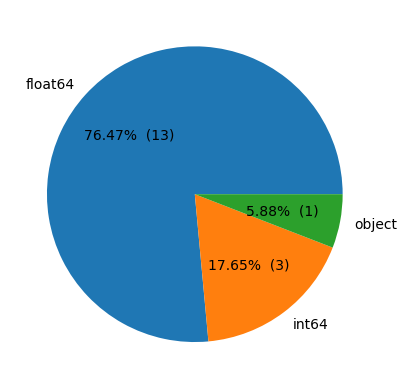


*******************************************************************************
                             DATA QUICK DESCRIPTION
*******************************************************************************



,tags,count,unique,top,freq,mean,std,min,25%,50%,75%,max,type,nan,nan_pct
AreaPerBldg(sf),,2159.0,2072,-,-,0.000023,0.000017,0.0,0.00001,0.00002,0.000034,0.000233,float64,0,0.00
AreaPerFloor(sf),,2159.0,2111,-,-,0.000068,0.000106,0.0,0.000032,0.000053,0.000091,0.004511,float64,0,0.00
BuildingRatio,,2159.0,441,-,-,0.940739,0.134979,0.104977,1.0,1.0,1.0,1.0,float64,0,0.00
ENERGYSTARScore,,1495.0,100,-,-,67.555184,28.260682,1.0,51.0,76.0,91.0,100.0,float64,664,30.75
Electricity_I(kBtu/sf),,2159.0,2158,-,-,39.072021,44.273572,-2.219558,18.300627,27.216548,43.776863,834.402417,float64,0,0.00
GHGEmissionsIntensity,,2159.0,473,-,-,1.372168,2.12884,-0.02,0.27,0.69,1.51,34.09,float64,0,0.00
NaturalGas_I(kBtu/sf),,2159.0,1456,-,-,18.498735,35.26978,0.0,0.0,7.471295,20.982234,602.037043,float64,0,0.00
Neighborhood,📦,2159.0,13,DOWNTOWN,426,-,-,-,-,-,-,-,object,0,0.00
NonResidentialRatio,,2159.0,924,-,-,0.678766,0.382155,0.012124,0.25948,1.0,1.0,1.0,float64,0,0.00
NumberofBuildings,,2159.0,16,-,-,1.181566,2.599532,1.0,1.0,1.0,1.0,111.0,float64,0,0.00


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024EAB56AEE0>



*******************************************************************************
                                 MISSING DATA
*******************************************************************************



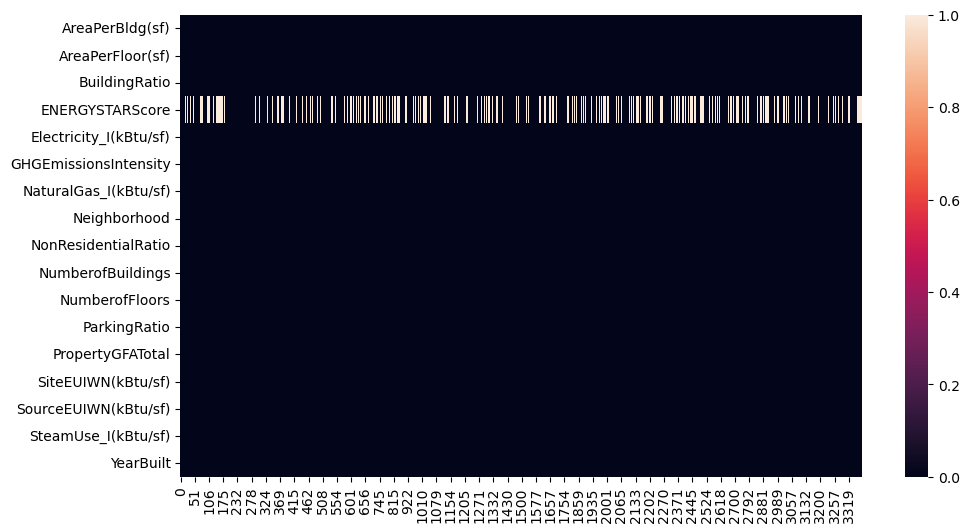

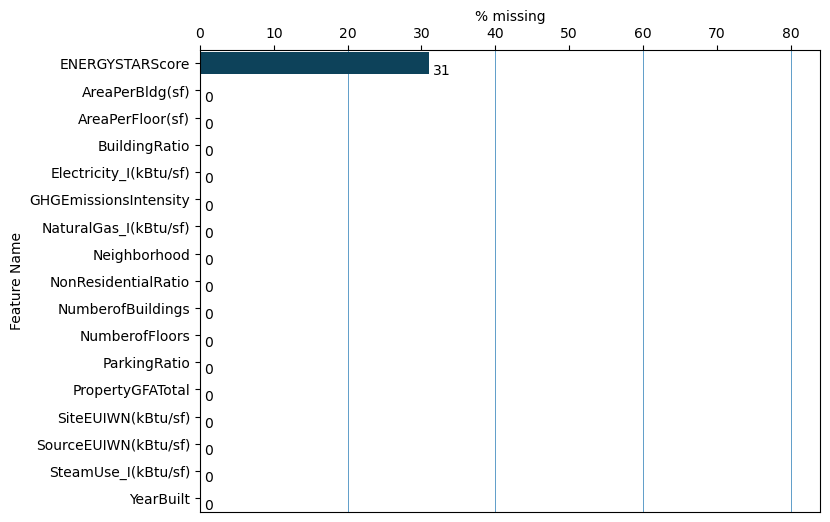

In [51]:
_ = data_overview(df_clean)

## <a id='toc5_1_'></a>[Outliers statistiques](#toc0_)

Bien que les outliers métier aient été ôtés, une visualisation par boxplots permet de visualiser rapidement les outliers statistiques éventuels.

> Pour rappel, les boîtes à moustaches ou boxplots représentent la distribution avec plusieurs éléments statistiques :
> - minimum
> - maximum
> - médiane (Q2)
> - Q1 et Q3, les premier et troisième quartiles (il y a 25% des individus sous Q1, 50% sous la médiane alias Q2 et 75% sous Q3)
> - moyenne (si option activée)
> - écart-type (si option activée)
> - et les outliers, représentés individuellement
> 
> Les outliers des boxplots sont définis par la **méthode IQR** (Interquartile Ratio), avec la formule suivante :  
> $$IQR = Q3 - Q1$$  
> Les outliers sont ainsi les valeurs **supérieures à $Q3 + (1.5 \cdot IQR)$ et inférieures à $Q1 - (1.5 \cdot IQR)$**.

In [52]:
distri_cor(df_clean, df_clean.columns)

Un filtre **IQR serait trop sélectif** ici et il resterait trop peu de données.  
De surcroît, il s'agit **non pas d'outliers mais de valeurs atypiques** : une **sélection manuelle, plus sélective et ciblée**, pourra déjà permettre un filtre léger qui améliore la qualité des données sans trop impacter la population.  
Un filtre plus sélectif devrait nécessairement être effectué par une personne de métier.

Au vu des boxplots, le filtre léger à appliquer serait le suivant :

In [53]:
def outliers_surgery(df, verbose=True):
    """
    Specific function that filters precisely a dataframe according to the
    previous EDA.
    """
    
    def add_index(index_list):
        for i in index_list:
            if i not in outliers: outliers.append(i)

    df_ = df.copy()
    outliers = []

    # complete filter of personalized stastical outliers
    add_index(df_.loc[df_["AreaPerFloor(sf)"] > 0.004].index)
    add_index(df_.loc[df_["BuildingRatio"] < 0.4].index)
    add_index(df_.loc[df_["Electricity_I(kBtu/sf)"] > 350].index)
    add_index(df_.loc[df_["GHGEmissionsIntensity"] > 20].index)
    add_index(df_.loc[df_["NumberofBuildings"] > 20].index)
    add_index(df_.loc[df_["NumberofFloors"] > 40].index)
    add_index(df_.loc[df_["ParkingRatio"] > 0.6].index)
    add_index(df_.loc[df_["PropertyGFATotal"] > 2000000].index)
    add_index(df_.loc[df_["ParkingRatio"] > 1].index)
    add_index(df_.loc[df_["SteamUse_I(kBtu/sf)"] > 100].index)

    outliers.sort()
    df_ = df_.drop(index=outliers)

    # delete last useless features
    df_ = delete_useless_feats(df_, ["NumberofBuildings", "NumberofFloors"],
        verbose=False)

    if verbose:
        logging.info(f"{outliers = }")
        impact(df, df_)

    return df_

df = outliers_surgery(df_clean, verbose=True)

INFO:root:outliers = [2, 35, 43, 105, 163, 170, 221, 222, 229, 231, 233, 240, 256, 260, 261, 271, 273, 291, 292, 309, 356, 373, 404, 432, 488, 490, 509, 558, 559, 577, 599, 602, 666, 809, 830, 943, 1109, 1165, 1255, 1285, 1327, 1335, 1359, 1365, 1481, 1494, 1672, 1753, 1862, 1947, 2206, 2511, 2592, 2675, 2800, 2932, 3063, 3124, 3134, 3156, 3160, 3171, 3189, 3203, 3233, 3264, 3267, 3274, 3294, 3302, 3322, 3349]


,Columns,Population
Before,17,2159
After,15,2087
Difference,2,72
Prct,11.76%,3.33%
IMPACT,+,--


INFO:root:None


Peu d'individus ont été retirés et les données sont de meilleure qualité :

In [54]:
display(describe_df(df))
distri_cor(df, df.columns)

,tags,count,unique,top,freq,mean,std,min,25%,50%,75%,max,type,nan,nan_pct
AreaPerBldg(sf),,2087.0,2001,-,-,0.000023,0.000017,0.000001,0.00001,0.000021,0.000034,0.000233,float64,0,0.00
AreaPerFloor(sf),,2087.0,2040,-,-,0.000066,0.000046,0.000001,0.000032,0.000054,0.000092,0.000321,float64,0,0.00
BuildingRatio,,2087.0,406,-,-,0.947224,0.119636,0.409128,1.0,1.0,1.0,1.0,float64,0,0.00
ENERGYSTARScore,,1451.0,100,-,-,67.349414,28.230283,1.0,51.0,75.0,91.0,100.0,float64,636,30.47
Electricity_I(kBtu/sf),,2087.0,2086,-,-,36.979266,33.747476,-2.219558,18.209998,26.60648,43.100008,293.115813,float64,0,0.00
GHGEmissionsIntensity,,2087.0,459,-,-,1.305443,1.817944,-0.02,0.27,0.68,1.5,16.99,float64,0,0.00
NaturalGas_I(kBtu/sf),,2087.0,1405,-,-,18.118873,31.356291,0.0,0.0,7.655202,21.268632,306.377567,float64,0,0.00
Neighborhood,📦,2087.0,13,DOWNTOWN,399,-,-,-,-,-,-,-,object,0,0.00
NonResidentialRatio,,2087.0,881,-,-,0.678311,0.384122,0.012124,0.258609,1.0,1.0,1.0,float64,0,0.00
ParkingRatio,,2087.0,968,-,-,0.116669,0.150734,0.0,0.0,0.0,0.228926,0.59962,float64,0,0.00


## <a id='toc5_2_'></a>[Corrélations](#toc0_)

c:\Users\jlemaire\AppData\Local\anaconda3\envs\OC\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



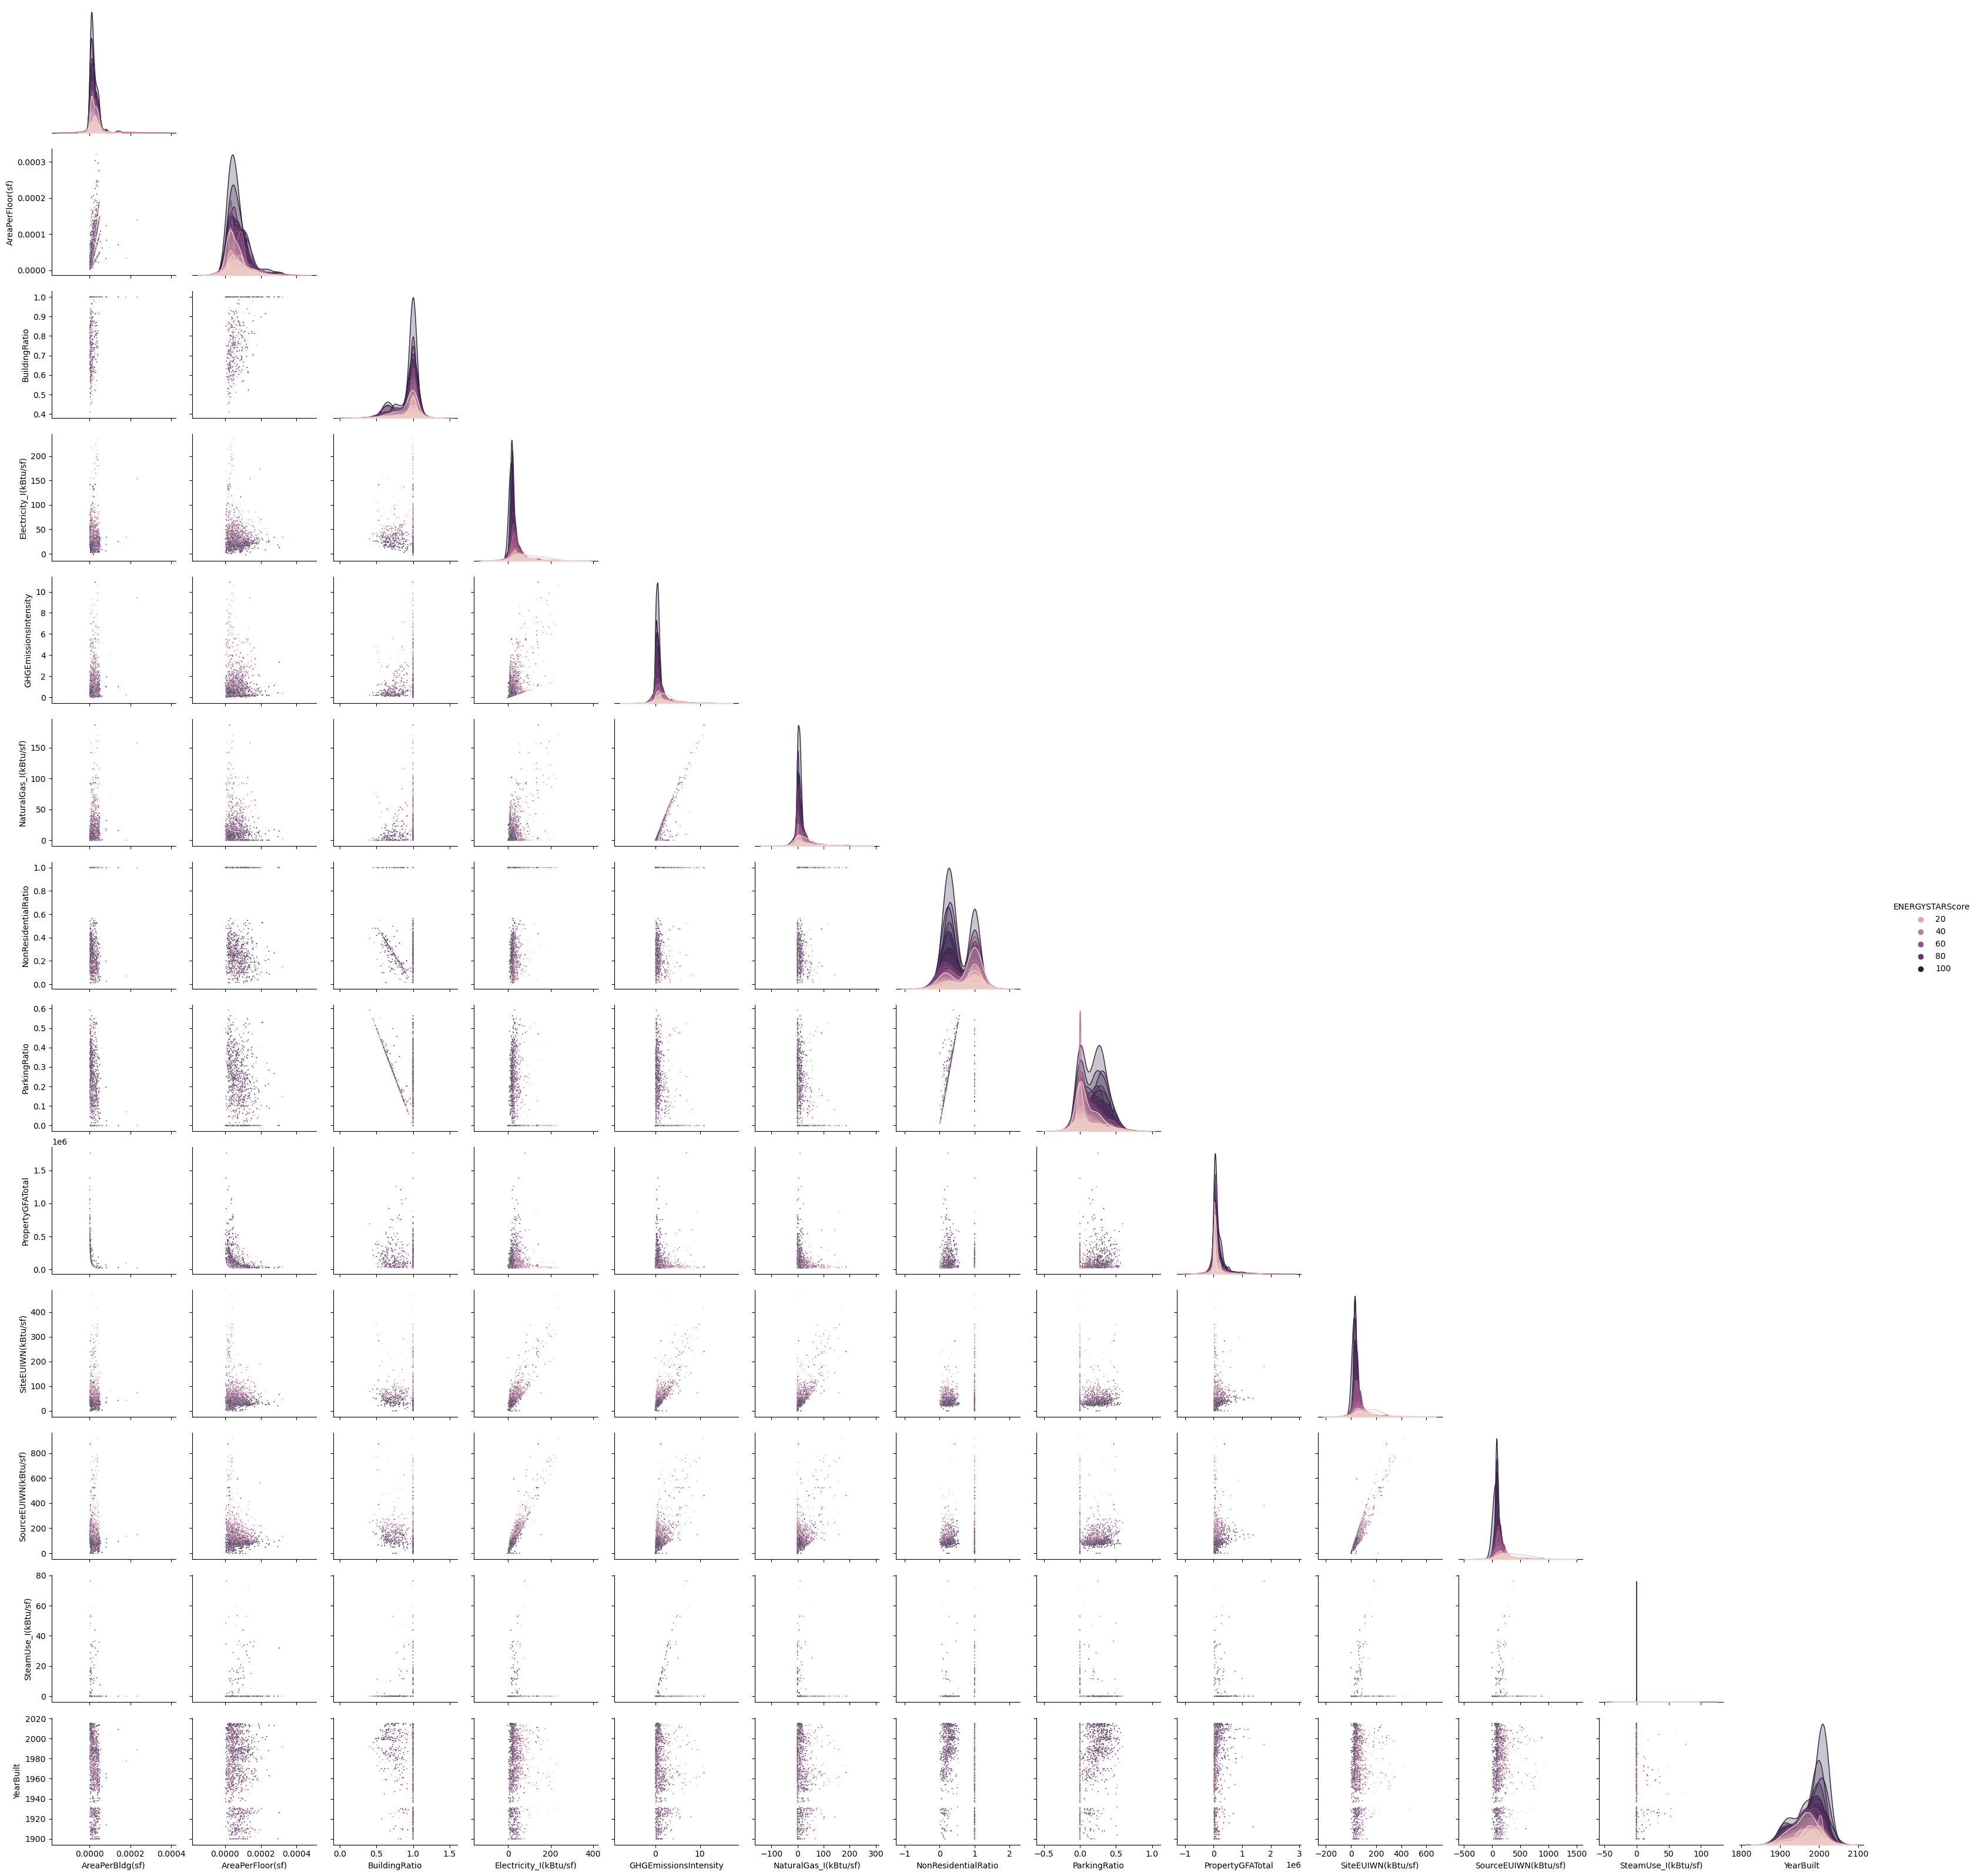

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000024EAF03B220>


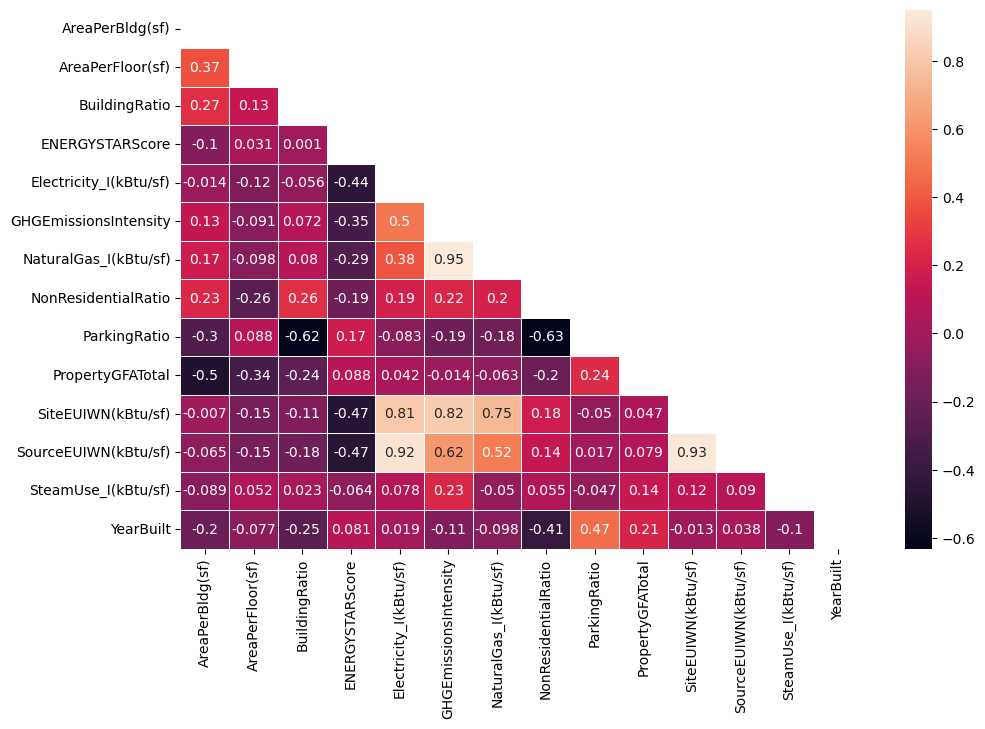

In [55]:
distri_cor(df, df.columns,
    target="ENERGYSTARScore",
    boxplot=False, pairplot=True, corr=True)

## <a id='toc5_3_'></a>[Variables cibles](#toc0_)

Pour rappel, la variable `GHGEmissionsIntensity` avait été choisie ci-avant pour les **émissions de CO2**, à la fois pour sa pertinence et sa normalisation par rapport à la surface de l'immeuble.

Pour la **consommation totale d'énergie**, la variable qui semble plus pertinente après étude est `SiteEUIWN(kBtu/sf)` :
- elle est propre au site, contrairement à `SourceEUIWN(kBtu/sf)` qui, bien que pertinente, dépend de ressources externes, telles que la génération, la transmission et la distribution de l'énergie
- `SourceEUIWN(kBtu/sf)` est très corrélée à `SiteEUIWN(kBtu/sf)` et à `Electricity_I(kBtu/sf)`

La variable `SourceEUIWN(kBtu/sf)` sera donc supprimée du jeu de données final :

In [56]:
df.drop(columns=["SourceEUIWN(kBtu/sf)"], inplace=True)

# <a id='toc6_'></a>[Conclusion](#toc0_)

Le jeu de données maintenant nettoyé est prêt aux prochains traitements de machine learning.